In [7]:
# !pip3 install pyarrow
# !pip3 install lightgbm
# !pip3 install optuna

In [8]:
import pandas as pd
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display

In [9]:
def preprocess(df, year):
    df[['Env', 'Hybrid']] = df['id'].str.split(':', expand=True)
    df['Env'] += "_" + str(year)
    df = df.drop('id', axis=1).set_index(['Env', 'Hybrid'])
    return df

In [10]:
%%time

ytrain = pd.read_csv('../output/ytrain.csv').set_index(['Env', 'Hybrid'])
xtrain = pd.read_parquet('../output/kronecker_dominant_train.parquet')
xtrain = preprocess(xtrain, year=2020)
xtrain = xtrain.merge(ytrain, on=['Env', 'Hybrid'], how='inner')
ytrain = xtrain['Yield_Mg_ha']
del xtrain['Yield_Mg_ha']

yval = pd.read_csv('../output/yval.csv').set_index(['Env', 'Hybrid'])
xval = pd.read_parquet('../output/kronecker_dominant_val.parquet')
xval = preprocess(xval, year=2021)
xval = xval.merge(yval, on=['Env', 'Hybrid'], how='inner')
yval = xval['Yield_Mg_ha']
del xval['Yield_Mg_ha']

CPU times: user 14min 37s, sys: 2min 56s, total: 17min 33s
Wall time: 17min 46s


In [11]:
xtrain

weather_station_lat.2369.DK3IIH6  \
Env       Hybrid                                                
DEH1_2020 B14A/H95                                   0.050461   
          B14A/MO17                                  0.856094   
          B14A/OH43                                  0.515439   
          B37/H95                                    1.201727   
          B37/MO17                                   1.593357   
...                                                       ...   
WIH3_2020 W10004_1123/PHP02                          2.104509   
          W10004_1140/PHP02                          2.568844   
          W10004_1143/PHP02                          1.460210   
          W10004_1146/PHP02                          3.717973   
          W10004_1156/PHP02                          3.647389   

                             weather_station_lat.2369.PHN82  \
Env       Hybrid                                              
DEH1_2020 B14A/H95                                 0.240077   
          B14A/MO17                                1.025778   
          B14A/OH43                                0.322950   
          B37/H95                                  1.452248   
          B37/MO17                                 1.397237   
...                                                     ...   
WIH3_2020 W10004_1123/PHP02                        2.873542   
          W10004_1140/PHP02                        4.076132   
          W10004_1143/PHP02                        1.249307   
          W10004_1146/PHP02                        5.836321   
          W10004_1156/PHP02                        4.977663   

                             weather_station_lat.2369.PHZ51  \
Env       Hybrid                                              
DEH1_2020 B14A/H95                                 0.683655   
          B14A/MO17                                2.073281   
          B14A/OH43                                0.686083   
          B37/H95                                  1.189368   
          B37/MO17                                 1.575667   
...                                                     ...   
WIH3_2020 W10004_1123/PHP02                        1.010831   
          W10004_1140/PHP02                        1.917314   
          W10004_1143/PHP02                        1.752785   
          W10004_1146/PHP02                        1.702453   
          W10004_1156/PHP02                        2.142653   

                             weather_station_lat.2FACC.DK3IIH6  \
Env       Hybrid                                                 
DEH1_2020 B14A/H95                                   -0.304615   
          B14A/MO17                                   0.266906   
          B14A/OH43                                  -0.018462   
          B37/H95                                    -0.409855   
          B37/MO17                                   -0.861833   
...                                                        ...   
WIH3_2020 W10004_1123/PHP02                          -0.051301   
          W10004_1140/PHP02                          -0.419973   
          W10004_1143/PHP02                          -2.084166   
          W10004_1146/PHP02                          -0.784281   
          W10004_1156/PHP02                          -1.027999   

                             weather_station_lat.4N506.DK3IIH6  \
Env       Hybrid                                                 
DEH1_2020 B14A/H95                                    0.318632   
          B14A/MO17                                   0.742284   
          B14A/OH43                                   0.700655   
          B37/H95                                     0.725291   
          B37/MO17                                    1.329050   
...                                                        ...   
WIH3_2020 W10004_1123/PHP02                           1.494538   
          W10004_1140/PHP02                           2.347449   
          W10004_1143/PH

### Training

In [12]:
# %%time

# NCOLS = xtrain.shape[1]
# print('features:', NCOLS)

# best_params = {'feature_fraction': 0.4953070809776986, 'num_leaves': 247, 
#                'bagging_fraction': 0.9866458243098336, 'lambda_l1': 3.680660098838679, 
#                'lambda_l2': 1.1632141265265e-06, 'n_estimators': 232, 'max_depth': 3}
# model = lgbm.LGBMRegressor(random_state=42, **best_params)
# model.fit(xtrain.iloc[:, :NCOLS], ytrain)

# # predict
# ypred = model.predict(xval.iloc[:, :NCOLS])

# # validate
# df_eval = pd.DataFrame()
# df_eval['Env'] = xval.index.get_level_values(0)
# df_eval['ytrue'] = list(yval)
# df_eval['ypred'] = ypred
# rmse_per_group = df_eval.groupby('Env').apply(lambda x: mean_squared_error(x['ytrue'], x['ypred'], squared=False))
# print(rmse_per_group)

# rmse = sum(rmse_per_group) / len(rmse_per_group)
# print('RMSE:', rmse)

In [13]:
# print(r2_score(df_eval['ytrue'], df_eval['ypred']))
# df_eval.plot.scatter('ytrue', 'ypred', figsize=(6, 6));

In [14]:
from sklearn.decomposition import TruncatedSVD

In [32]:
%%time

n_components = 150
svd = TruncatedSVD(n_components=n_components, random_state=42)
svd.fit(xtrain)
print(svd.explained_variance_ratio_.sum())

0.9472180372134749
CPU times: user 6min 44s, sys: 9.57 s, total: 6min 54s
Wall time: 7min 12s


In [33]:
%%time

xtrain_svd = pd.DataFrame(svd.transform(xtrain), index=xtrain.index)
xtrain_svd.columns = [f'kron_svd{i}' for i in range(n_components)]

xval_svd = pd.DataFrame(svd.transform(xval), index=xval.index)
xval_svd.columns = [f'kron_svd{i}' for i in range(n_components)]

CPU times: user 1min 12s, sys: 8.97 ms, total: 1min 12s
Wall time: 1min 14s


In [34]:
xtrain_lag = pd.read_csv('../output/xtrain.csv', usecols=lambda x: 'yield_lag' in x or x in ['Env', 'Hybrid']).set_index(['Env', 'Hybrid'])
xval_lag = pd.read_csv('../output/xval.csv', usecols=lambda x: 'yield_lag' in x or x in ['Env', 'Hybrid']).set_index(['Env', 'Hybrid'])
xtrain_svd = xtrain_svd.merge(xtrain_lag, on=['Env', 'Hybrid'], how='inner')
xval_svd = xval_svd.merge(xval_lag, on=['Env', 'Hybrid'], how='inner')

In [35]:
xtrain_svd

kron_svd0    kron_svd1    kron_svd2  \
Env       Hybrid                                                      
DEH1_2020 B14A/H95            2648.884922    -3.572925   864.217307   
          B14A/MO17           5900.635738    77.602703  1466.179076   
          B14A/OH43           3900.819493   323.594963  1658.778053   
          B37/H95             4927.400998   900.147340  1045.849196   
          B37/MO17            8367.472197   615.523370  1548.796716   
...                                   ...          ...          ...   
WIH3_2020 W10004_1123/PHP02   4636.607959  6400.926165 -2781.007201   
          W10004_1140/PHP02  11800.766335  8076.135642 -4567.834304   
          W10004_1143/PHP02  10297.814429  7170.445874 -4067.472788   
          W10004_1146/PHP02  11300.579790  8828.830708 -4577.825250   
          W10004_1156/PHP02   9699.082449  6524.364435 -4018.918563   

                               kron_svd3    kron_svd4    kron_svd5  \
Env       Hybrid                                                     
DEH1_2020 B14A/H95           -145.403653   173.159032   629.946149   
          B14A/MO17          -490.770171   432.875784  1753.540902   
          B14A/OH43            61.519295   209.795346   744.926288   
          B37/H95            -180.890307   293.632264  1139.627749   
          B37/MO17           -710.032727   454.199509  1552.829489   
...                                  ...          ...          ...   
WIH3_2020 W10004_1123/PHP02  2416.467572  2023.407812  -689.883067   
          W10004_1140/PHP02  5222.571669  4652.867345  2786.003786   
          W10004_1143/PHP02  4553.854079  4040.608153  2210.618654   
          W10004_1146/PHP02  5170.332666  4491.377746  1915.075009   
          W10004_1156/PHP02  4199.719062  3784.126618  2143.401084   

                               kron_svd6    kron_svd7    kron_svd8  \
Env       Hybrid                                                     
DEH1_2020 B14A/H95           -130.641121   830.353036   693.053921   
          B14A/MO17          -454.552220   717.045527  1573.931356   
          B14A/OH43          -148.022523   994.161436  1169.960155   
          B37/H95            -265.579695  1296.077496   565.526725   
          B37/MO17           -288.703305  2414.589844  1092.261229   
...                                  ...          ...          ...   
WIH3_2020 W10004_1123/PHP02  6231.028724 -2452.580532 -1280.347900   
          W10004_1140/PHP02  9186.042856  -261.526679  -201.718029   
          W10004_1143/PHP02  8167.318091 -1193.092237  2221.887429   
          W10004_1146/PHP02  9735.458535  -976.806609  -399.875351   
          W10004_1156/PHP02  7547.002075  -471.625612 -1252.755539   

                               kron_svd9  ...  kron_svd146  kron_svd147  \
Env       Hybrid                          ...                             
DEH1_2020 B14A/H95            -94.500088  ...   160.393326   151.036386   
          B14A/MO17         -1714.365314  ...    45.986576  -663.580688   
          B14A/OH43          -323.167946  ...   100.000337    77.548241   
          B37/H95             258.616843  ...    74.484751    11.602260   
          B37/MO17           -935.344479  ...   -41.004499   124.406941   
...                                  ...  ...          ...          ...   
WIH3_2020 W10004_1123/PHP02 -2116.266921  ...  -283.170590  -336.369105   
          W10004_1140/PHP02   677.192154  ...   307.141027   105.384668   
          W10004_1143/PHP02  2296.613849  ...  -294.141410   250.517369   
          W10004_1146/PHP02  -728.820655  ...   126.938394  -161.460461   
          W10004_1156/PHP02  -859.828381  ...  -114.480318  -235.023385   

                             kron_svd148  kron_svd149  mean_yield_lag_2  \
Env       Hybrid                                                          
DEH1_2020 B14A/H95           -560.795992  -199.541739         10.056423   
          B14A/MO17          1134.346365  -267.657624         10.056423   
          

In [36]:
import optuna

In [37]:
def objective(trial):
    """
    https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258
    """
    params = {

#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.0, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'deterministic': True,
        'random_state': 42
    }
    
    model2 = lgbm.LGBMRegressor(**params)
    model2.fit(xtrain_svd, ytrain)

    # predict
    ypred2 = model2.predict(xval_svd)

    # validate
    df_eval2 = pd.DataFrame()
    df_eval2['Env'] = xval_svd.index.get_level_values(0)
    df_eval2['ytrue'] = list(yval)
    df_eval2['ypred'] = ypred2
    rmse_per_group2 = df_eval2.groupby('Env').apply(lambda x: mean_squared_error(x['ytrue'], x['ypred'], squared=False))
    # print(rmse_per_group2)

    rmse2 = sum(rmse_per_group2) / len(rmse_per_group2)
    return rmse2


study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=200)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best RMSE:', study.best_value)

[I 2023-01-31 22:20:42,648] A new study created in memory with name: no-name-8337c144-6b3e-4e25-912c-e24282ecc390


[LightGBM] [Warning] lambda_l1 is set=0.0024430162614261413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024430162614261413
[LightGBM] [Warning] bagging_fraction is set=0.839196365086843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.839196365086843
[LightGBM] [Warning] feature_fraction is set=0.3745401188473625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3745401188473625
[LightGBM] [Warning] lambda_l2 is set=2.5361081166471375e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5361081166471375e-07


[I 2023-01-31 22:20:43,214] Trial 0 finished with value: 2.2900031587909484 and parameters: {'feature_fraction': 0.3745401188473625, 'num_leaves': 244, 'bagging_fraction': 0.839196365086843, 'lambda_l1': 0.0024430162614261413, 'lambda_l2': 2.5361081166471375e-07, 'n_estimators': 55, 'max_depth': 2}. Best is trial 0 with value: 2.2900031587909484.


[LightGBM] [Warning] lambda_l1 is set=1.5320059381854043e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5320059381854043e-08
[LightGBM] [Warning] bagging_fraction is set=0.8248435466776274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8248435466776274
[LightGBM] [Warning] feature_fraction is set=0.8661761457749352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8661761457749352
[LightGBM] [Warning] lambda_l2 is set=5.360294728728285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.360294728728285


[I 2023-01-31 22:20:45,150] Trial 1 finished with value: 2.208942915002342 and parameters: {'feature_fraction': 0.8661761457749352, 'num_leaves': 155, 'bagging_fraction': 0.8248435466776274, 'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285, 'n_estimators': 252, 'max_depth': 3}. Best is trial 1 with value: 2.208942915002342.


[LightGBM] [Warning] lambda_l1 is set=0.00052821153945323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00052821153945323
[LightGBM] [Warning] bagging_fraction is set=0.5825453457757226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5825453457757226
[LightGBM] [Warning] feature_fraction is set=0.18182496720710062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18182496720710062
[LightGBM] [Warning] lambda_l2 is set=7.71800699380605e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.71800699380605e-05


[I 2023-01-31 22:20:45,920] Trial 2 finished with value: 2.21667853964373 and parameters: {'feature_fraction': 0.18182496720710062, 'num_leaves': 48, 'bagging_fraction': 0.5825453457757226, 'lambda_l1': 0.00052821153945323, 'lambda_l2': 7.71800699380605e-05, 'n_estimators': 94, 'max_depth': 5}. Best is trial 1 with value: 2.208942915002342.


[LightGBM] [Warning] lambda_l1 is set=0.00012724181576752517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012724181576752517
[LightGBM] [Warning] bagging_fraction is set=0.619817105976215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.619817105976215
[LightGBM] [Warning] feature_fraction is set=0.13949386065204183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13949386065204183
[LightGBM] [Warning] lambda_l2 is set=0.1165691561324743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1165691561324743


[I 2023-01-31 22:20:46,467] Trial 3 finished with value: 2.257171403062729 and parameters: {'feature_fraction': 0.13949386065204183, 'num_leaves': 76, 'bagging_fraction': 0.619817105976215, 'lambda_l1': 0.00012724181576752517, 'lambda_l2': 0.1165691561324743, 'n_estimators': 68, 'max_depth': 4}. Best is trial 1 with value: 2.208942915002342.


[LightGBM] [Warning] lambda_l1 is set=3.425445902633376e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.425445902633376e-07
[LightGBM] [Warning] bagging_fraction is set=0.764526911140863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.764526911140863
[LightGBM] [Warning] feature_fraction is set=0.5924145688620425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5924145688620425
[LightGBM] [Warning] lambda_l2 is set=3.850031979199519e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.850031979199519e-08


[I 2023-01-31 22:20:48,914] Trial 4 finished with value: 2.2342547884197774 and parameters: {'feature_fraction': 0.5924145688620425, 'num_leaves': 13, 'bagging_fraction': 0.764526911140863, 'lambda_l1': 3.425445902633376e-07, 'lambda_l2': 3.850031979199519e-08, 'n_estimators': 286, 'max_depth': 6}. Best is trial 1 with value: 2.208942915002342.


[LightGBM] [Warning] lambda_l1 is set=0.014391207615728067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014391207615728067
[LightGBM] [Warning] bagging_fraction is set=0.45860326840383037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45860326840383037
[LightGBM] [Warning] feature_fraction is set=0.8083973481164611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8083973481164611
[LightGBM] [Warning] lambda_l2 is set=9.148975058772307e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.148975058772307e-05


[I 2023-01-31 22:20:49,726] Trial 5 finished with value: 2.2883358877611073 and parameters: {'feature_fraction': 0.8083973481164611, 'num_leaves': 79, 'bagging_fraction': 0.45860326840383037, 'lambda_l1': 0.014391207615728067, 'lambda_l2': 9.148975058772307e-05, 'n_estimators': 45, 'max_depth': 4}. Best is trial 1 with value: 2.208942915002342.


[LightGBM] [Warning] lambda_l1 is set=0.009176996354542699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009176996354542699
[LightGBM] [Warning] bagging_fraction is set=0.5552679889600102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5552679889600102
[LightGBM] [Warning] feature_fraction is set=0.034388521115218396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.034388521115218396
[LightGBM] [Warning] lambda_l2 is set=6.388511557344611e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.388511557344611e-06


[I 2023-01-31 22:20:50,317] Trial 6 finished with value: 2.2325002291893323 and parameters: {'feature_fraction': 0.034388521115218396, 'num_leaves': 233, 'bagging_fraction': 0.5552679889600102, 'lambda_l1': 0.009176996354542699, 'lambda_l2': 6.388511557344611e-06, 'n_estimators': 161, 'max_depth': 4}. Best is trial 1 with value: 2.208942915002342.


[LightGBM] [Warning] lambda_l1 is set=2.854239907497756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854239907497756
[LightGBM] [Warning] bagging_fraction is set=0.8650796940166687, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8650796940166687
[LightGBM] [Warning] feature_fraction is set=0.18485445552552704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18485445552552704
[LightGBM] [Warning] lambda_l2 is set=1.1309571585271483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1309571585271483


[I 2023-01-31 22:20:51,811] Trial 7 finished with value: 2.259121453248013 and parameters: {'feature_fraction': 0.18485445552552704, 'num_leaves': 249, 'bagging_fraction': 0.8650796940166687, 'lambda_l1': 2.854239907497756, 'lambda_l2': 1.1309571585271483, 'n_estimators': 183, 'max_depth': 6}. Best is trial 1 with value: 2.208942915002342.


[LightGBM] [Warning] lambda_l1 is set=8.471746987003668e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.471746987003668e-06
[LightGBM] [Warning] bagging_fraction is set=0.4271363733463229, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4271363733463229
[LightGBM] [Warning] feature_fraction is set=0.0884925020519195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0884925020519195
[LightGBM] [Warning] lambda_l2 is set=3.148441347423712e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.148441347423712e-05


[I 2023-01-31 22:20:52,515] Trial 8 finished with value: 2.248722267522445 and parameters: {'feature_fraction': 0.0884925020519195, 'num_leaves': 51, 'bagging_fraction': 0.4271363733463229, 'lambda_l1': 8.471746987003668e-06, 'lambda_l2': 3.148441347423712e-05, 'n_estimators': 88, 'max_depth': 6}. Best is trial 1 with value: 2.208942915002342.


[LightGBM] [Warning] lambda_l1 is set=1.8548894229694903e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8548894229694903e-07
[LightGBM] [Warning] bagging_fraction is set=0.7256176498949491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7256176498949491
[LightGBM] [Warning] feature_fraction is set=0.3567533266935893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3567533266935893
[LightGBM] [Warning] lambda_l2 is set=0.16587190283399655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16587190283399655


[I 2023-01-31 22:20:53,267] Trial 9 finished with value: 2.3090820887278163 and parameters: {'feature_fraction': 0.3567533266935893, 'num_leaves': 73, 'bagging_fraction': 0.7256176498949491, 'lambda_l1': 1.8548894229694903e-07, 'lambda_l2': 0.16587190283399655, 'n_estimators': 31, 'max_depth': 6}. Best is trial 1 with value: 2.208942915002342.


[LightGBM] [Warning] lambda_l1 is set=1.4509648127973792e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4509648127973792e-08
[LightGBM] [Warning] bagging_fraction is set=0.9817222664727197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9817222664727197
[LightGBM] [Warning] feature_fraction is set=0.9788450993760263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9788450993760263
[LightGBM] [Warning] lambda_l2 is set=7.162312742007019, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.162312742007019


[I 2023-01-31 22:20:54,905] Trial 10 finished with value: 2.227085336242566 and parameters: {'feature_fraction': 0.9788450993760263, 'num_leaves': 169, 'bagging_fraction': 0.9817222664727197, 'lambda_l1': 1.4509648127973792e-08, 'lambda_l2': 7.162312742007019, 'n_estimators': 274, 'max_depth': 2}. Best is trial 1 with value: 2.208942915002342.


[LightGBM] [Warning] lambda_l1 is set=4.2401486791772944e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2401486791772944e-05
[LightGBM] [Warning] bagging_fraction is set=0.6277625460521341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6277625460521341
[LightGBM] [Warning] feature_fraction is set=0.6240835271723653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6240835271723653
[LightGBM] [Warning] lambda_l2 is set=0.003606535878052327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003606535878052327


[I 2023-01-31 22:20:56,294] Trial 11 finished with value: 2.2068922720699846 and parameters: {'feature_fraction': 0.6240835271723653, 'num_leaves': 147, 'bagging_fraction': 0.6277625460521341, 'lambda_l1': 4.2401486791772944e-05, 'lambda_l2': 0.003606535878052327, 'n_estimators': 212, 'max_depth': 3}. Best is trial 11 with value: 2.2068922720699846.


[LightGBM] [Warning] lambda_l1 is set=1.4219003669558993e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4219003669558993e-08
[LightGBM] [Warning] bagging_fraction is set=0.6767848264649009, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6767848264649009
[LightGBM] [Warning] feature_fraction is set=0.6941538791952222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6941538791952222
[LightGBM] [Warning] lambda_l2 is set=0.00566647307995475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00566647307995475


[I 2023-01-31 22:20:57,843] Trial 12 finished with value: 2.218821315873246 and parameters: {'feature_fraction': 0.6941538791952222, 'num_leaves': 150, 'bagging_fraction': 0.6767848264649009, 'lambda_l1': 1.4219003669558993e-08, 'lambda_l2': 0.00566647307995475, 'n_estimators': 229, 'max_depth': 3}. Best is trial 11 with value: 2.2068922720699846.


[LightGBM] [Warning] lambda_l1 is set=1.1774187730846638e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1774187730846638e-05
[LightGBM] [Warning] bagging_fraction is set=0.7862503832657425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7862503832657425
[LightGBM] [Warning] feature_fraction is set=0.8243291718565097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8243291718565097
[LightGBM] [Warning] lambda_l2 is set=0.002643768213226745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002643768213226745


[I 2023-01-31 22:20:59,487] Trial 13 finished with value: 2.2117398545477878 and parameters: {'feature_fraction': 0.8243291718565097, 'num_leaves': 198, 'bagging_fraction': 0.7862503832657425, 'lambda_l1': 1.1774187730846638e-05, 'lambda_l2': 0.002643768213226745, 'n_estimators': 213, 'max_depth': 3}. Best is trial 11 with value: 2.2068922720699846.


[LightGBM] [Warning] lambda_l1 is set=1.5951852231307057e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5951852231307057e-06
[LightGBM] [Warning] bagging_fraction is set=0.6628781004946807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6628781004946807
[LightGBM] [Warning] feature_fraction is set=0.5731283352968769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5731283352968769
[LightGBM] [Warning] lambda_l2 is set=0.008953500118828728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008953500118828728


[I 2023-01-31 22:21:00,920] Trial 14 finished with value: 2.188957321764655 and parameters: {'feature_fraction': 0.5731283352968769, 'num_leaves': 121, 'bagging_fraction': 0.6628781004946807, 'lambda_l1': 1.5951852231307057e-06, 'lambda_l2': 0.008953500118828728, 'n_estimators': 240, 'max_depth': 3}. Best is trial 14 with value: 2.188957321764655.


[LightGBM] [Warning] lambda_l1 is set=3.850344231091819e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.850344231091819e-06
[LightGBM] [Warning] bagging_fraction is set=0.6798527371979727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6798527371979727
[LightGBM] [Warning] feature_fraction is set=0.5267178503381676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5267178503381676
[LightGBM] [Warning] lambda_l2 is set=0.0013910472630127636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013910472630127636


[I 2023-01-31 22:21:01,863] Trial 15 finished with value: 2.1806054436516993 and parameters: {'feature_fraction': 0.5267178503381676, 'num_leaves': 115, 'bagging_fraction': 0.6798527371979727, 'lambda_l1': 3.850344231091819e-06, 'lambda_l2': 0.0013910472630127636, 'n_estimators': 130, 'max_depth': 3}. Best is trial 15 with value: 2.1806054436516993.


[LightGBM] [Warning] lambda_l1 is set=2.5828651825635327e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5828651825635327e-06
[LightGBM] [Warning] bagging_fraction is set=0.6833931770003209, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6833931770003209
[LightGBM] [Warning] feature_fraction is set=0.4853101961974619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4853101961974619
[LightGBM] [Warning] lambda_l2 is set=0.0014693130148192672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014693130148192672


[I 2023-01-31 22:21:02,605] Trial 16 finished with value: 2.2265711859783415 and parameters: {'feature_fraction': 0.4853101961974619, 'num_leaves': 103, 'bagging_fraction': 0.6833931770003209, 'lambda_l1': 2.5828651825635327e-06, 'lambda_l2': 0.0014693130148192672, 'n_estimators': 130, 'max_depth': 2}. Best is trial 15 with value: 2.1806054436516993.


[LightGBM] [Warning] lambda_l1 is set=1.7213796995744496e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7213796995744496e-06
[LightGBM] [Warning] bagging_fraction is set=0.5243495374973053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5243495374973053
[LightGBM] [Warning] feature_fraction is set=0.48682298868239626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48682298868239626
[LightGBM] [Warning] lambda_l2 is set=0.027498478684639407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.027498478684639407


[I 2023-01-31 22:21:04,249] Trial 17 finished with value: 2.207620459153409 and parameters: {'feature_fraction': 0.48682298868239626, 'num_leaves': 113, 'bagging_fraction': 0.5243495374973053, 'lambda_l1': 1.7213796995744496e-06, 'lambda_l2': 0.027498478684639407, 'n_estimators': 144, 'max_depth': 5}. Best is trial 15 with value: 2.1806054436516993.


[LightGBM] [Warning] lambda_l1 is set=4.2725611578301204e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2725611578301204e-07
[LightGBM] [Warning] bagging_fraction is set=0.6569800266131068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6569800266131068
[LightGBM] [Warning] feature_fraction is set=0.708199627059164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.708199627059164
[LightGBM] [Warning] lambda_l2 is set=0.0004394187293746708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004394187293746708


[I 2023-01-31 22:21:05,248] Trial 18 finished with value: 2.2281416264363787 and parameters: {'feature_fraction': 0.708199627059164, 'num_leaves': 117, 'bagging_fraction': 0.6569800266131068, 'lambda_l1': 4.2725611578301204e-07, 'lambda_l2': 0.0004394187293746708, 'n_estimators': 113, 'max_depth': 3}. Best is trial 15 with value: 2.1806054436516993.


[LightGBM] [Warning] lambda_l1 is set=3.756984803624391e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.756984803624391e-05
[LightGBM] [Warning] bagging_fraction is set=0.5119076588281573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5119076588281573
[LightGBM] [Warning] feature_fraction is set=0.3731286158022053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3731286158022053
[LightGBM] [Warning] lambda_l2 is set=0.018114557682839833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018114557682839833


[I 2023-01-31 22:21:06,843] Trial 19 finished with value: 2.216045440047484 and parameters: {'feature_fraction': 0.3731286158022053, 'num_leaves': 203, 'bagging_fraction': 0.5119076588281573, 'lambda_l1': 3.756984803624391e-05, 'lambda_l2': 0.018114557682839833, 'n_estimators': 174, 'max_depth': 5}. Best is trial 15 with value: 2.1806054436516993.


[LightGBM] [Warning] lambda_l1 is set=2.3803087778760937e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3803087778760937e-06
[LightGBM] [Warning] bagging_fraction is set=0.7266028972225247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7266028972225247
[LightGBM] [Warning] feature_fraction is set=0.5736894675055919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5736894675055919
[LightGBM] [Warning] lambda_l2 is set=0.0009018306933260857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009018306933260857


[I 2023-01-31 22:21:07,300] Trial 20 finished with value: 2.3475806883076342 and parameters: {'feature_fraction': 0.5736894675055919, 'num_leaves': 132, 'bagging_fraction': 0.7266028972225247, 'lambda_l1': 2.3803087778760937e-06, 'lambda_l2': 0.0009018306933260857, 'n_estimators': 13, 'max_depth': 2}. Best is trial 15 with value: 2.1806054436516993.


[LightGBM] [Warning] lambda_l1 is set=6.437556856826782e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.437556856826782e-05
[LightGBM] [Warning] bagging_fraction is set=0.6282345841254573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6282345841254573
[LightGBM] [Warning] feature_fraction is set=0.6080407600824593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6080407600824593
[LightGBM] [Warning] lambda_l2 is set=0.007775621397232339, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007775621397232339


[I 2023-01-31 22:21:08,676] Trial 21 finished with value: 2.1961647207675896 and parameters: {'feature_fraction': 0.6080407600824593, 'num_leaves': 186, 'bagging_fraction': 0.6282345841254573, 'lambda_l1': 6.437556856826782e-05, 'lambda_l2': 0.007775621397232339, 'n_estimators': 214, 'max_depth': 3}. Best is trial 15 with value: 2.1806054436516993.


[LightGBM] [Warning] lambda_l1 is set=0.00016807658166580503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016807658166580503
[LightGBM] [Warning] bagging_fraction is set=0.6029660974705682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6029660974705682
[LightGBM] [Warning] feature_fraction is set=0.4854042651771475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4854042651771475
[LightGBM] [Warning] lambda_l2 is set=0.03097301274448999, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03097301274448999


[I 2023-01-31 22:21:10,013] Trial 22 finished with value: 2.1736713382118826 and parameters: {'feature_fraction': 0.4854042651771475, 'num_leaves': 183, 'bagging_fraction': 0.6029660974705682, 'lambda_l1': 0.00016807658166580503, 'lambda_l2': 0.03097301274448999, 'n_estimators': 245, 'max_depth': 3}. Best is trial 22 with value: 2.1736713382118826.


[LightGBM] [Warning] lambda_l1 is set=0.00045307811702003915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00045307811702003915
[LightGBM] [Warning] bagging_fraction is set=0.5897155100222029, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5897155100222029
[LightGBM] [Warning] feature_fraction is set=0.46432190117886324, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46432190117886324
[LightGBM] [Warning] lambda_l2 is set=0.08175250986304114, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08175250986304114


[I 2023-01-31 22:21:11,829] Trial 23 finished with value: 2.221613971556058 and parameters: {'feature_fraction': 0.46432190117886324, 'num_leaves': 216, 'bagging_fraction': 0.5897155100222029, 'lambda_l1': 0.00045307811702003915, 'lambda_l2': 0.08175250986304114, 'n_estimators': 256, 'max_depth': 4}. Best is trial 22 with value: 2.1736713382118826.


[LightGBM] [Warning] lambda_l1 is set=5.7625793724134645e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7625793724134645e-06
[LightGBM] [Warning] bagging_fraction is set=0.6786055622650762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6786055622650762
[LightGBM] [Warning] feature_fraction is set=0.2935025764178031, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2935025764178031
[LightGBM] [Warning] lambda_l2 is set=0.3704831879627753, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3704831879627753


[I 2023-01-31 22:21:12,741] Trial 24 finished with value: 2.2049299231341677 and parameters: {'feature_fraction': 0.2935025764178031, 'num_leaves': 176, 'bagging_fraction': 0.6786055622650762, 'lambda_l1': 5.7625793724134645e-06, 'lambda_l2': 0.3704831879627753, 'n_estimators': 190, 'max_depth': 3}. Best is trial 22 with value: 2.1736713382118826.


[LightGBM] [Warning] lambda_l1 is set=2.037775686461657e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.037775686461657e-05
[LightGBM] [Warning] bagging_fraction is set=0.558857685679696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.558857685679696
[LightGBM] [Warning] feature_fraction is set=0.518111264166547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.518111264166547
[LightGBM] [Warning] lambda_l2 is set=0.028928182064975765, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.028928182064975765


[I 2023-01-31 22:21:13,944] Trial 25 finished with value: 2.1944279422199364 and parameters: {'feature_fraction': 0.518111264166547, 'num_leaves': 95, 'bagging_fraction': 0.558857685679696, 'lambda_l1': 2.037775686461657e-05, 'lambda_l2': 0.028928182064975765, 'n_estimators': 300, 'max_depth': 2}. Best is trial 22 with value: 2.1736713382118826.


[LightGBM] [Warning] lambda_l1 is set=8.60641569311367e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.60641569311367e-08
[LightGBM] [Warning] bagging_fraction is set=0.7206101618483481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7206101618483481
[LightGBM] [Warning] feature_fraction is set=0.43358204520398036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43358204520398036
[LightGBM] [Warning] lambda_l2 is set=0.0005759846961227872, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005759846961227872


[I 2023-01-31 22:21:15,196] Trial 26 finished with value: 2.1669911534151844 and parameters: {'feature_fraction': 0.43358204520398036, 'num_leaves': 137, 'bagging_fraction': 0.7206101618483481, 'lambda_l1': 8.60641569311367e-08, 'lambda_l2': 0.0005759846961227872, 'n_estimators': 243, 'max_depth': 3}. Best is trial 26 with value: 2.1669911534151844.


[LightGBM] [Warning] lambda_l1 is set=2.824814853999103e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.824814853999103e-07
[LightGBM] [Warning] bagging_fraction is set=0.7200750787865646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7200750787865646
[LightGBM] [Warning] feature_fraction is set=0.42724370136617784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42724370136617784
[LightGBM] [Warning] lambda_l2 is set=0.00023642801592487807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00023642801592487807


[I 2023-01-31 22:21:16,319] Trial 27 finished with value: 2.2302716239385285 and parameters: {'feature_fraction': 0.42724370136617784, 'num_leaves': 137, 'bagging_fraction': 0.7200750787865646, 'lambda_l1': 2.824814853999103e-07, 'lambda_l2': 0.00023642801592487807, 'n_estimators': 137, 'max_depth': 4}. Best is trial 26 with value: 2.1669911534151844.


[LightGBM] [Warning] lambda_l1 is set=1.4243954575500328e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4243954575500328e-07
[LightGBM] [Warning] bagging_fraction is set=0.624258441669555, subsample=1.0 will be ignored. Current value: bagging_fraction=0.624258441669555
[LightGBM] [Warning] feature_fraction is set=0.2774408878337792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2774408878337792
[LightGBM] [Warning] lambda_l2 is set=0.0010682542476310186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010682542476310186


[I 2023-01-31 22:21:17,214] Trial 28 finished with value: 2.2186254024181 and parameters: {'feature_fraction': 0.2774408878337792, 'num_leaves': 163, 'bagging_fraction': 0.624258441669555, 'lambda_l1': 1.4243954575500328e-07, 'lambda_l2': 0.0010682542476310186, 'n_estimators': 196, 'max_depth': 3}. Best is trial 26 with value: 2.1669911534151844.


[LightGBM] [Warning] lambda_l1 is set=6.263449513500064e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.263449513500064e-08
[LightGBM] [Warning] bagging_fraction is set=0.7523313843239432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7523313843239432
[LightGBM] [Warning] feature_fraction is set=0.40519611781100173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40519611781100173
[LightGBM] [Warning] lambda_l2 is set=5.559588846444375e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.559588846444375e-06


[I 2023-01-31 22:21:18,209] Trial 29 finished with value: 2.2063042187808346 and parameters: {'feature_fraction': 0.40519611781100173, 'num_leaves': 226, 'bagging_fraction': 0.7523313843239432, 'lambda_l1': 6.263449513500064e-08, 'lambda_l2': 5.559588846444375e-06, 'n_estimators': 268, 'max_depth': 2}. Best is trial 26 with value: 2.1669911534151844.


[LightGBM] [Warning] lambda_l1 is set=0.00019154415757894483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019154415757894483
[LightGBM] [Warning] bagging_fraction is set=0.7000909022077737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7000909022077737
[LightGBM] [Warning] feature_fraction is set=0.5220472627487514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5220472627487514
[LightGBM] [Warning] lambda_l2 is set=0.0003243453231697705, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003243453231697705


[I 2023-01-31 22:21:19,061] Trial 30 finished with value: 2.203859590247073 and parameters: {'feature_fraction': 0.5220472627487514, 'num_leaves': 181, 'bagging_fraction': 0.7000909022077737, 'lambda_l1': 0.00019154415757894483, 'lambda_l2': 0.0003243453231697705, 'n_estimators': 163, 'max_depth': 2}. Best is trial 26 with value: 2.1669911534151844.


[LightGBM] [Warning] lambda_l1 is set=1.1704395468901325e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1704395468901325e-06
[LightGBM] [Warning] bagging_fraction is set=0.6460737194880147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6460737194880147
[LightGBM] [Warning] feature_fraction is set=0.4354215960238237, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4354215960238237
[LightGBM] [Warning] lambda_l2 is set=0.00846090207719939, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00846090207719939


[I 2023-01-31 22:21:20,304] Trial 31 finished with value: 2.166644108736241 and parameters: {'feature_fraction': 0.4354215960238237, 'num_leaves': 135, 'bagging_fraction': 0.6460737194880147, 'lambda_l1': 1.1704395468901325e-06, 'lambda_l2': 0.00846090207719939, 'n_estimators': 240, 'max_depth': 3}. Best is trial 31 with value: 2.166644108736241.


[LightGBM] [Warning] lambda_l1 is set=5.843487965345146e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.843487965345146e-07
[LightGBM] [Warning] bagging_fraction is set=0.6496901104987606, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6496901104987606
[LightGBM] [Warning] feature_fraction is set=0.45022019873451086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45022019873451086
[LightGBM] [Warning] lambda_l2 is set=0.002408201665503749, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002408201665503749


[I 2023-01-31 22:21:21,554] Trial 32 finished with value: 2.1699051205769675 and parameters: {'feature_fraction': 0.45022019873451086, 'num_leaves': 136, 'bagging_fraction': 0.6496901104987606, 'lambda_l1': 5.843487965345146e-07, 'lambda_l2': 0.002408201665503749, 'n_estimators': 239, 'max_depth': 3}. Best is trial 31 with value: 2.166644108736241.


[LightGBM] [Warning] lambda_l1 is set=5.040248749730115e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.040248749730115e-08
[LightGBM] [Warning] bagging_fraction is set=0.5995975964424655, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5995975964424655
[LightGBM] [Warning] feature_fraction is set=0.41441252642410276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41441252642410276
[LightGBM] [Warning] lambda_l2 is set=0.03380304520498747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03380304520498747


[I 2023-01-31 22:21:22,760] Trial 33 finished with value: 2.1505521351670147 and parameters: {'feature_fraction': 0.41441252642410276, 'num_leaves': 139, 'bagging_fraction': 0.5995975964424655, 'lambda_l1': 5.040248749730115e-08, 'lambda_l2': 0.03380304520498747, 'n_estimators': 237, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=4.4822492243308335e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4822492243308335e-08
[LightGBM] [Warning] bagging_fraction is set=0.639019257001695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639019257001695
[LightGBM] [Warning] feature_fraction is set=0.33159546667186307, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33159546667186307
[LightGBM] [Warning] lambda_l2 is set=0.006279190009599302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006279190009599302


[I 2023-01-31 22:21:24,114] Trial 34 finished with value: 2.246765349151495 and parameters: {'feature_fraction': 0.33159546667186307, 'num_leaves': 140, 'bagging_fraction': 0.639019257001695, 'lambda_l1': 4.4822492243308335e-08, 'lambda_l2': 0.006279190009599302, 'n_estimators': 229, 'max_depth': 4}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=6.274832202059582e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.274832202059582e-08
[LightGBM] [Warning] bagging_fraction is set=0.5581914144502795, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5581914144502795
[LightGBM] [Warning] feature_fraction is set=0.4154914779865069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4154914779865069
[LightGBM] [Warning] lambda_l2 is set=0.7240246171179443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7240246171179443


[I 2023-01-31 22:21:25,431] Trial 35 finished with value: 2.151565634512285 and parameters: {'feature_fraction': 0.4154914779865069, 'num_leaves': 160, 'bagging_fraction': 0.5581914144502795, 'lambda_l1': 6.274832202059582e-08, 'lambda_l2': 0.7240246171179443, 'n_estimators': 268, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=4.467898796654959e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.467898796654959e-08
[LightGBM] [Warning] bagging_fraction is set=0.5711290992866499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5711290992866499
[LightGBM] [Warning] feature_fraction is set=0.397372177819184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.397372177819184
[LightGBM] [Warning] lambda_l2 is set=0.5729669188912583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5729669188912583


[I 2023-01-31 22:21:27,108] Trial 36 finished with value: 2.2290334548984405 and parameters: {'feature_fraction': 0.397372177819184, 'num_leaves': 160, 'bagging_fraction': 0.5711290992866499, 'lambda_l1': 4.467898796654959e-08, 'lambda_l2': 0.5729669188912583, 'n_estimators': 265, 'max_depth': 4}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=6.910102386033689e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.910102386033689e-08
[LightGBM] [Warning] bagging_fraction is set=0.5852680697728326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5852680697728326
[LightGBM] [Warning] feature_fraction is set=0.25481047377456656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25481047377456656
[LightGBM] [Warning] lambda_l2 is set=1.3657420558196576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3657420558196576


[I 2023-01-31 22:21:27,978] Trial 37 finished with value: 2.2287937978074845 and parameters: {'feature_fraction': 0.25481047377456656, 'num_leaves': 94, 'bagging_fraction': 0.5852680697728326, 'lambda_l1': 6.910102386033689e-08, 'lambda_l2': 1.3657420558196576, 'n_estimators': 284, 'max_depth': 2}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=1.4154257294988802e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4154257294988802e-08
[LightGBM] [Warning] bagging_fraction is set=0.5284618710402076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5284618710402076
[LightGBM] [Warning] feature_fraction is set=0.3294698207272665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3294698207272665
[LightGBM] [Warning] lambda_l2 is set=2.4379991540247934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4379991540247934


[I 2023-01-31 22:21:29,609] Trial 38 finished with value: 2.2410949586338473 and parameters: {'feature_fraction': 0.3294698207272665, 'num_leaves': 155, 'bagging_fraction': 0.5284618710402076, 'lambda_l1': 1.4154257294988802e-08, 'lambda_l2': 2.4379991540247934, 'n_estimators': 294, 'max_depth': 4}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=6.245795483634494e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.245795483634494e-07
[LightGBM] [Warning] bagging_fraction is set=0.4885535392722035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4885535392722035
[LightGBM] [Warning] feature_fraction is set=0.4198535815051106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4198535815051106
[LightGBM] [Warning] lambda_l2 is set=0.09164834107547112, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09164834107547112


[I 2023-01-31 22:21:30,809] Trial 39 finished with value: 2.1606472640106316 and parameters: {'feature_fraction': 0.4198535815051106, 'num_leaves': 6, 'bagging_fraction': 0.4885535392722035, 'lambda_l1': 6.245795483634494e-07, 'lambda_l2': 0.09164834107547112, 'n_estimators': 256, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=7.463926464766053e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.463926464766053e-07
[LightGBM] [Warning] bagging_fraction is set=0.4806855006138103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4806855006138103
[LightGBM] [Warning] feature_fraction is set=0.20847702078555108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20847702078555108
[LightGBM] [Warning] lambda_l2 is set=0.18408483064953368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.18408483064953368


[I 2023-01-31 22:21:31,951] Trial 40 finished with value: 2.2807623360191465 and parameters: {'feature_fraction': 0.20847702078555108, 'num_leaves': 10, 'bagging_fraction': 0.4806855006138103, 'lambda_l1': 7.463926464766053e-07, 'lambda_l2': 0.18408483064953368, 'n_estimators': 277, 'max_depth': 4}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=9.032350130356827e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.032350130356827e-08
[LightGBM] [Warning] bagging_fraction is set=0.4882326511711042, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4882326511711042
[LightGBM] [Warning] feature_fraction is set=0.41915971558768894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41915971558768894
[LightGBM] [Warning] lambda_l2 is set=0.07051884933465417, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07051884933465417


[I 2023-01-31 22:21:33,204] Trial 41 finished with value: 2.1547011485592864 and parameters: {'feature_fraction': 0.41915971558768894, 'num_leaves': 38, 'bagging_fraction': 0.4882326511711042, 'lambda_l1': 9.032350130356827e-08, 'lambda_l2': 0.07051884933465417, 'n_estimators': 252, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=2.2845871561345815e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2845871561345815e-07
[LightGBM] [Warning] bagging_fraction is set=0.4816490700058229, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4816490700058229
[LightGBM] [Warning] feature_fraction is set=0.3828207422189281, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3828207422189281
[LightGBM] [Warning] lambda_l2 is set=0.0604157858089957, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0604157858089957


[I 2023-01-31 22:21:34,338] Trial 42 finished with value: 2.1766053818679563 and parameters: {'feature_fraction': 0.3828207422189281, 'num_leaves': 28, 'bagging_fraction': 0.4816490700058229, 'lambda_l1': 2.2845871561345815e-07, 'lambda_l2': 0.0604157858089957, 'n_estimators': 226, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=3.381230618111153e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.381230618111153e-08
[LightGBM] [Warning] bagging_fraction is set=0.407356102943389, subsample=1.0 will be ignored. Current value: bagging_fraction=0.407356102943389
[LightGBM] [Warning] feature_fraction is set=0.34051238048599725, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34051238048599725
[LightGBM] [Warning] lambda_l2 is set=0.2878209853667225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2878209853667225


[I 2023-01-31 22:21:35,493] Trial 43 finished with value: 2.2039627630250087 and parameters: {'feature_fraction': 0.34051238048599725, 'num_leaves': 31, 'bagging_fraction': 0.407356102943389, 'lambda_l1': 3.381230618111153e-08, 'lambda_l2': 0.2878209853667225, 'n_estimators': 258, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=7.313393039494772e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.313393039494772e-07
[LightGBM] [Warning] bagging_fraction is set=0.5401874959819339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5401874959819339
[LightGBM] [Warning] feature_fraction is set=0.42669122905726053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42669122905726053
[LightGBM] [Warning] lambda_l2 is set=0.0918345401694746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0918345401694746


[I 2023-01-31 22:21:36,604] Trial 44 finished with value: 2.1763611625575296 and parameters: {'feature_fraction': 0.42669122905726053, 'num_leaves': 57, 'bagging_fraction': 0.5401874959819339, 'lambda_l1': 7.313393039494772e-07, 'lambda_l2': 0.0918345401694746, 'n_estimators': 201, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=1.6732556284066045e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6732556284066045e-07
[LightGBM] [Warning] bagging_fraction is set=0.4422044188039167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4422044188039167
[LightGBM] [Warning] feature_fraction is set=0.3782444147929103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3782444147929103
[LightGBM] [Warning] lambda_l2 is set=0.567256486316274, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.567256486316274


[I 2023-01-31 22:21:37,347] Trial 45 finished with value: 2.2847552381327056 and parameters: {'feature_fraction': 0.3782444147929103, 'num_leaves': 2, 'bagging_fraction': 0.4422044188039167, 'lambda_l1': 1.6732556284066045e-07, 'lambda_l2': 0.567256486316274, 'n_estimators': 255, 'max_depth': 4}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=2.407838506084373e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.407838506084373e-08
[LightGBM] [Warning] bagging_fraction is set=0.49987425988477013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49987425988477013
[LightGBM] [Warning] feature_fraction is set=0.2430808642829482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2430808642829482
[LightGBM] [Warning] lambda_l2 is set=3.837792699016645, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.837792699016645


[I 2023-01-31 22:21:38,204] Trial 46 finished with value: 2.2390488193459195 and parameters: {'feature_fraction': 0.2430808642829482, 'num_leaves': 27, 'bagging_fraction': 0.49987425988477013, 'lambda_l1': 2.407838506084373e-08, 'lambda_l2': 3.837792699016645, 'n_estimators': 284, 'max_depth': 2}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=1.2916422014167447e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2916422014167447e-08
[LightGBM] [Warning] bagging_fraction is set=0.550318885625241, subsample=1.0 will be ignored. Current value: bagging_fraction=0.550318885625241
[LightGBM] [Warning] feature_fraction is set=0.29595632737613264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29595632737613264
[LightGBM] [Warning] lambda_l2 is set=0.17995263936675981, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17995263936675981


[I 2023-01-31 22:21:39,852] Trial 47 finished with value: 2.241177430361154 and parameters: {'feature_fraction': 0.29595632737613264, 'num_leaves': 58, 'bagging_fraction': 0.550318885625241, 'lambda_l1': 1.2916422014167447e-08, 'lambda_l2': 0.17995263936675981, 'n_estimators': 221, 'max_depth': 5}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=1.1043213088555912e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1043213088555912e-07
[LightGBM] [Warning] bagging_fraction is set=0.462667497358049, subsample=1.0 will be ignored. Current value: bagging_fraction=0.462667497358049
[LightGBM] [Warning] feature_fraction is set=0.4543632259190948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4543632259190948
[LightGBM] [Warning] lambda_l2 is set=0.06744033898880784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06744033898880784


[I 2023-01-31 22:21:41,211] Trial 48 finished with value: 2.1655132635008645 and parameters: {'feature_fraction': 0.4543632259190948, 'num_leaves': 36, 'bagging_fraction': 0.462667497358049, 'lambda_l1': 1.1043213088555912e-07, 'lambda_l2': 0.06744033898880784, 'n_estimators': 264, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=1.107870588104353e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.107870588104353e-07
[LightGBM] [Warning] bagging_fraction is set=0.46059231275876517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46059231275876517
[LightGBM] [Warning] feature_fraction is set=0.5307244122306518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5307244122306518
[LightGBM] [Warning] lambda_l2 is set=1.0885814840643888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0885814840643888


[I 2023-01-31 22:21:42,725] Trial 49 finished with value: 2.177290563963371 and parameters: {'feature_fraction': 0.5307244122306518, 'num_leaves': 37, 'bagging_fraction': 0.46059231275876517, 'lambda_l1': 1.107870588104353e-07, 'lambda_l2': 1.0885814840643888, 'n_estimators': 269, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=2.4161960703925436e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4161960703925436e-08
[LightGBM] [Warning] bagging_fraction is set=0.4873540100200358, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4873540100200358
[LightGBM] [Warning] feature_fraction is set=0.3546307486960134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3546307486960134
[LightGBM] [Warning] lambda_l2 is set=5.571428262580436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.571428262580436


[I 2023-01-31 22:21:43,697] Trial 50 finished with value: 2.220577225661859 and parameters: {'feature_fraction': 0.3546307486960134, 'num_leaves': 70, 'bagging_fraction': 0.4873540100200358, 'lambda_l1': 2.4161960703925436e-08, 'lambda_l2': 5.571428262580436, 'n_estimators': 280, 'max_depth': 2}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=1.0610016269805385e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0610016269805385e-06
[LightGBM] [Warning] bagging_fraction is set=0.5118459188219329, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5118459188219329
[LightGBM] [Warning] feature_fraction is set=0.4507300408737786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4507300408737786
[LightGBM] [Warning] lambda_l2 is set=0.06015674059134317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06015674059134317


[I 2023-01-31 22:21:44,943] Trial 51 finished with value: 2.1726245110717164 and parameters: {'feature_fraction': 0.4507300408737786, 'num_leaves': 15, 'bagging_fraction': 0.5118459188219329, 'lambda_l1': 1.0610016269805385e-06, 'lambda_l2': 0.06015674059134317, 'n_estimators': 236, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=3.4769817909383556e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4769817909383556e-07
[LightGBM] [Warning] bagging_fraction is set=0.4621568301932336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4621568301932336
[LightGBM] [Warning] feature_fraction is set=0.42276938932979524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42276938932979524
[LightGBM] [Warning] lambda_l2 is set=0.021275058042235322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021275058042235322


[I 2023-01-31 22:21:46,200] Trial 52 finished with value: 2.187463627728427 and parameters: {'feature_fraction': 0.42276938932979524, 'num_leaves': 18, 'bagging_fraction': 0.4621568301932336, 'lambda_l1': 3.4769817909383556e-07, 'lambda_l2': 0.021275058042235322, 'n_estimators': 250, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=1.3199539400080636e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3199539400080636e-07
[LightGBM] [Warning] bagging_fraction is set=0.5433923608791037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5433923608791037
[LightGBM] [Warning] feature_fraction is set=0.39489761316437794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39489761316437794
[LightGBM] [Warning] lambda_l2 is set=0.13821744991519616, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13821744991519616


[I 2023-01-31 22:21:47,468] Trial 53 finished with value: 2.172308402950534 and parameters: {'feature_fraction': 0.39489761316437794, 'num_leaves': 41, 'bagging_fraction': 0.5433923608791037, 'lambda_l1': 1.3199539400080636e-07, 'lambda_l2': 0.13821744991519616, 'n_estimators': 263, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=3.673679320224029e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.673679320224029e-07
[LightGBM] [Warning] bagging_fraction is set=0.4314257768315956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4314257768315956
[LightGBM] [Warning] feature_fraction is set=0.4755737164946431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4755737164946431
[LightGBM] [Warning] lambda_l2 is set=0.00998390521309746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00998390521309746


[I 2023-01-31 22:21:48,653] Trial 54 finished with value: 2.181439519727284 and parameters: {'feature_fraction': 0.4755737164946431, 'num_leaves': 47, 'bagging_fraction': 0.4314257768315956, 'lambda_l1': 3.673679320224029e-07, 'lambda_l2': 0.00998390521309746, 'n_estimators': 207, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=1.592495580923552e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.592495580923552e-06
[LightGBM] [Warning] bagging_fraction is set=0.60054521373658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.60054521373658
[LightGBM] [Warning] feature_fraction is set=0.5498712456956194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5498712456956194
[LightGBM] [Warning] lambda_l2 is set=0.04517229931821596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04517229931821596


[I 2023-01-31 22:21:50,109] Trial 55 finished with value: 2.182625359403936 and parameters: {'feature_fraction': 0.5498712456956194, 'num_leaves': 125, 'bagging_fraction': 0.60054521373658, 'lambda_l1': 1.592495580923552e-06, 'lambda_l2': 0.04517229931821596, 'n_estimators': 251, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=3.9378418322075574e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9378418322075574e-08
[LightGBM] [Warning] bagging_fraction is set=0.5261833531285802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5261833531285802
[LightGBM] [Warning] feature_fraction is set=0.49373500186004615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49373500186004615
[LightGBM] [Warning] lambda_l2 is set=0.015260943698841968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015260943698841968


[I 2023-01-31 22:21:51,625] Trial 56 finished with value: 2.1754805435272773 and parameters: {'feature_fraction': 0.49373500186004615, 'num_leaves': 82, 'bagging_fraction': 0.5261833531285802, 'lambda_l1': 3.9378418322075574e-08, 'lambda_l2': 0.015260943698841968, 'n_estimators': 292, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=1.039466916302288e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.039466916302288e-08
[LightGBM] [Warning] bagging_fraction is set=0.5670172468381767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5670172468381767
[LightGBM] [Warning] feature_fraction is set=0.45608142487075665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45608142487075665
[LightGBM] [Warning] lambda_l2 is set=0.09391218373732765, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09391218373732765


[I 2023-01-31 22:21:52,311] Trial 57 finished with value: 2.184451480729566 and parameters: {'feature_fraction': 0.45608142487075665, 'num_leaves': 108, 'bagging_fraction': 0.5670172468381767, 'lambda_l1': 1.039466916302288e-08, 'lambda_l2': 0.09391218373732765, 'n_estimators': 71, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=4.2478171917246295e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2478171917246295e-06
[LightGBM] [Warning] bagging_fraction is set=0.49950173259852093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49950173259852093
[LightGBM] [Warning] feature_fraction is set=0.3138308004665404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3138308004665404
[LightGBM] [Warning] lambda_l2 is set=0.3335241926254425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3335241926254425


[I 2023-01-31 22:21:53,613] Trial 58 finished with value: 2.2583968131987255 and parameters: {'feature_fraction': 0.3138308004665404, 'num_leaves': 147, 'bagging_fraction': 0.49950173259852093, 'lambda_l1': 4.2478171917246295e-06, 'lambda_l2': 0.3335241926254425, 'n_estimators': 222, 'max_depth': 4}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=8.14821905554185e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.14821905554185e-08
[LightGBM] [Warning] bagging_fraction is set=0.450849733416201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.450849733416201
[LightGBM] [Warning] feature_fraction is set=0.3623145450643688, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3623145450643688
[LightGBM] [Warning] lambda_l2 is set=0.043010742005716446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.043010742005716446


[I 2023-01-31 22:21:54,382] Trial 59 finished with value: 2.215212776885576 and parameters: {'feature_fraction': 0.3623145450643688, 'num_leaves': 3, 'bagging_fraction': 0.450849733416201, 'lambda_l1': 8.14821905554185e-08, 'lambda_l2': 0.043010742005716446, 'n_estimators': 177, 'max_depth': 2}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=4.996387671214893e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.996387671214893e-07
[LightGBM] [Warning] bagging_fraction is set=0.6100063206942737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6100063206942737
[LightGBM] [Warning] feature_fraction is set=0.558980924550234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.558980924550234
[LightGBM] [Warning] lambda_l2 is set=0.0167365979951242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0167365979951242


[I 2023-01-31 22:21:55,936] Trial 60 finished with value: 2.185654874993078 and parameters: {'feature_fraction': 0.558980924550234, 'num_leaves': 169, 'bagging_fraction': 0.6100063206942737, 'lambda_l1': 4.996387671214893e-07, 'lambda_l2': 0.0167365979951242, 'n_estimators': 272, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=1.190495766569364e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.190495766569364e-07
[LightGBM] [Warning] bagging_fraction is set=0.4077773584173717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4077773584173717
[LightGBM] [Warning] feature_fraction is set=0.42846309450342207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42846309450342207
[LightGBM] [Warning] lambda_l2 is set=0.004985009833521007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004985009833521007


[I 2023-01-31 22:21:57,191] Trial 61 finished with value: 2.1869813166297045 and parameters: {'feature_fraction': 0.42846309450342207, 'num_leaves': 143, 'bagging_fraction': 0.4077773584173717, 'lambda_l1': 1.190495766569364e-07, 'lambda_l2': 0.004985009833521007, 'n_estimators': 247, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=2.0767771520360326e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0767771520360326e-07
[LightGBM] [Warning] bagging_fraction is set=0.5813998463838786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5813998463838786
[LightGBM] [Warning] feature_fraction is set=0.4918571763953428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4918571763953428
[LightGBM] [Warning] lambda_l2 is set=0.03829592014747732, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03829592014747732


[I 2023-01-31 22:21:58,520] Trial 62 finished with value: 2.194493349066011 and parameters: {'feature_fraction': 0.4918571763953428, 'num_leaves': 21, 'bagging_fraction': 0.5813998463838786, 'lambda_l1': 2.0767771520360326e-07, 'lambda_l2': 0.03829592014747732, 'n_estimators': 239, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=8.597685420177117e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.597685420177117e-08
[LightGBM] [Warning] bagging_fraction is set=0.6197089368232792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6197089368232792
[LightGBM] [Warning] feature_fraction is set=0.4065221939168613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4065221939168613
[LightGBM] [Warning] lambda_l2 is set=0.003890204019574269, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003890204019574269


[I 2023-01-31 22:21:59,790] Trial 63 finished with value: 2.177450885837532 and parameters: {'feature_fraction': 0.4065221939168613, 'num_leaves': 126, 'bagging_fraction': 0.6197089368232792, 'lambda_l1': 8.597685420177117e-08, 'lambda_l2': 0.003890204019574269, 'n_estimators': 260, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=2.7483724057082673e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7483724057082673e-08
[LightGBM] [Warning] bagging_fraction is set=0.5577556890519563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5577556890519563
[LightGBM] [Warning] feature_fraction is set=0.36418259955899246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36418259955899246
[LightGBM] [Warning] lambda_l2 is set=0.010505720542588913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010505720542588913


[I 2023-01-31 22:22:01,237] Trial 64 finished with value: 2.2310866386386303 and parameters: {'feature_fraction': 0.36418259955899246, 'num_leaves': 151, 'bagging_fraction': 0.5577556890519563, 'lambda_l1': 2.7483724057082673e-08, 'lambda_l2': 0.010505720542588913, 'n_estimators': 231, 'max_depth': 4}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=1.1629263035694799e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1629263035694799e-06
[LightGBM] [Warning] bagging_fraction is set=0.47063448070009134, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47063448070009134
[LightGBM] [Warning] feature_fraction is set=0.44820493149790575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44820493149790575
[LightGBM] [Warning] lambda_l2 is set=0.12174224691341419, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12174224691341419


[I 2023-01-31 22:22:02,523] Trial 65 finished with value: 2.1712648785636426 and parameters: {'feature_fraction': 0.44820493149790575, 'num_leaves': 131, 'bagging_fraction': 0.47063448070009134, 'lambda_l1': 1.1629263035694799e-06, 'lambda_l2': 0.12174224691341419, 'n_estimators': 246, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=2.542621035264736e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.542621035264736e-07
[LightGBM] [Warning] bagging_fraction is set=0.5150009286997149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5150009286997149
[LightGBM] [Warning] feature_fraction is set=0.5066892346126977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5066892346126977
[LightGBM] [Warning] lambda_l2 is set=0.002510484471481657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002510484471481657


[I 2023-01-31 22:22:03,784] Trial 66 finished with value: 2.1875759322682415 and parameters: {'feature_fraction': 0.5066892346126977, 'num_leaves': 191, 'bagging_fraction': 0.5150009286997149, 'lambda_l1': 2.542621035264736e-07, 'lambda_l2': 0.002510484471481657, 'n_estimators': 217, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=6.402691564845537e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.402691564845537e-08
[LightGBM] [Warning] bagging_fraction is set=0.6470057849005152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6470057849005152
[LightGBM] [Warning] feature_fraction is set=0.47227804984868305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47227804984868305
[LightGBM] [Warning] lambda_l2 is set=0.024918577248370013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024918577248370013


[I 2023-01-31 22:22:05,226] Trial 67 finished with value: 2.1877047832590044 and parameters: {'feature_fraction': 0.47227804984868305, 'num_leaves': 255, 'bagging_fraction': 0.6470057849005152, 'lambda_l1': 6.402691564845537e-08, 'lambda_l2': 0.024918577248370013, 'n_estimators': 276, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=8.176226372645461e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.176226372645461e-06
[LightGBM] [Warning] bagging_fraction is set=0.6639831050926547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6639831050926547
[LightGBM] [Warning] feature_fraction is set=0.41785607650291373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41785607650291373
[LightGBM] [Warning] lambda_l2 is set=0.19831517860502118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19831517860502118


[I 2023-01-31 22:22:06,317] Trial 68 finished with value: 2.205355320678604 and parameters: {'feature_fraction': 0.41785607650291373, 'num_leaves': 119, 'bagging_fraction': 0.6639831050926547, 'lambda_l1': 8.176226372645461e-06, 'lambda_l2': 0.19831517860502118, 'n_estimators': 299, 'max_depth': 2}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=2.5825094835786603e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5825094835786603e-06
[LightGBM] [Warning] bagging_fraction is set=0.4993891656539472, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4993891656539472
[LightGBM] [Warning] feature_fraction is set=0.33632800999487844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33632800999487844
[LightGBM] [Warning] lambda_l2 is set=0.07681130213325235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07681130213325235


[I 2023-01-31 22:22:07,722] Trial 69 finished with value: 2.2217989556153883 and parameters: {'feature_fraction': 0.33632800999487844, 'num_leaves': 171, 'bagging_fraction': 0.4993891656539472, 'lambda_l1': 2.5825094835786603e-06, 'lambda_l2': 0.07681130213325235, 'n_estimators': 236, 'max_depth': 4}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=2.1245154500296905e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1245154500296905e-08
[LightGBM] [Warning] bagging_fraction is set=0.5330052672580249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5330052672580249
[LightGBM] [Warning] feature_fraction is set=0.3767128351838834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3767128351838834
[LightGBM] [Warning] lambda_l2 is set=0.699412859126479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.699412859126479


[I 2023-01-31 22:22:09,041] Trial 70 finished with value: 2.1853148937421634 and parameters: {'feature_fraction': 0.3767128351838834, 'num_leaves': 101, 'bagging_fraction': 0.5330052672580249, 'lambda_l1': 2.1245154500296905e-08, 'lambda_l2': 0.699412859126479, 'n_estimators': 288, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=5.85016450015357e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.85016450015357e-07
[LightGBM] [Warning] bagging_fraction is set=0.6418365525759208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6418365525759208
[LightGBM] [Warning] feature_fraction is set=0.45612594865835493, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45612594865835493
[LightGBM] [Warning] lambda_l2 is set=0.00286931224876288, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00286931224876288


[I 2023-01-31 22:22:10,302] Trial 71 finished with value: 2.1578794730151016 and parameters: {'feature_fraction': 0.45612594865835493, 'num_leaves': 139, 'bagging_fraction': 0.6418365525759208, 'lambda_l1': 5.85016450015357e-07, 'lambda_l2': 0.00286931224876288, 'n_estimators': 236, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=5.169029363219888e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.169029363219888e-07
[LightGBM] [Warning] bagging_fraction is set=0.6323068766340244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6323068766340244
[LightGBM] [Warning] feature_fraction is set=0.44586075765811645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44586075765811645
[LightGBM] [Warning] lambda_l2 is set=0.007248840460920488, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007248840460920488


[I 2023-01-31 22:22:11,460] Trial 72 finished with value: 2.16847594462411 and parameters: {'feature_fraction': 0.44586075765811645, 'num_leaves': 155, 'bagging_fraction': 0.6323068766340244, 'lambda_l1': 5.169029363219888e-07, 'lambda_l2': 0.007248840460920488, 'n_estimators': 208, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=1.7721501180923702e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7721501180923702e-07
[LightGBM] [Warning] bagging_fraction is set=0.601598881796663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.601598881796663
[LightGBM] [Warning] feature_fraction is set=0.3966593631465267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3966593631465267
[LightGBM] [Warning] lambda_l2 is set=0.0019099296070659787, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019099296070659787


[I 2023-01-31 22:22:12,727] Trial 73 finished with value: 2.177918918435348 and parameters: {'feature_fraction': 0.3966593631465267, 'num_leaves': 139, 'bagging_fraction': 0.601598881796663, 'lambda_l1': 1.7721501180923702e-07, 'lambda_l2': 0.0019099296070659787, 'n_estimators': 263, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=5.247698562544098e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.247698562544098e-08
[LightGBM] [Warning] bagging_fraction is set=0.5778737352302544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5778737352302544
[LightGBM] [Warning] feature_fraction is set=0.5104233152328665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5104233152328665
[LightGBM] [Warning] lambda_l2 is set=0.0006290943207786881, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006290943207786881


[I 2023-01-31 22:22:14,087] Trial 74 finished with value: 2.1699318179560727 and parameters: {'feature_fraction': 0.5104233152328665, 'num_leaves': 164, 'bagging_fraction': 0.5778737352302544, 'lambda_l1': 5.247698562544098e-08, 'lambda_l2': 0.0006290943207786881, 'n_estimators': 241, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=7.349643709149245e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.349643709149245e-07
[LightGBM] [Warning] bagging_fraction is set=0.6618171702918465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6618171702918465
[LightGBM] [Warning] feature_fraction is set=0.4713743184882174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4713743184882174
[LightGBM] [Warning] lambda_l2 is set=0.003554265783960965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003554265783960965


[I 2023-01-31 22:22:15,194] Trial 75 finished with value: 2.1847610714914762 and parameters: {'feature_fraction': 0.4713743184882174, 'num_leaves': 111, 'bagging_fraction': 0.6618171702918465, 'lambda_l1': 7.349643709149245e-07, 'lambda_l2': 0.003554265783960965, 'n_estimators': 114, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=1.0063698502338723e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0063698502338723e-07
[LightGBM] [Warning] bagging_fraction is set=0.701841329707914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.701841329707914
[LightGBM] [Warning] feature_fraction is set=0.5944825610960501, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5944825610960501
[LightGBM] [Warning] lambda_l2 is set=0.011814717671914438, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011814717671914438


[I 2023-01-31 22:22:16,740] Trial 76 finished with value: 2.184644844440483 and parameters: {'feature_fraction': 0.5944825610960501, 'num_leaves': 128, 'bagging_fraction': 0.701841329707914, 'lambda_l1': 1.0063698502338723e-07, 'lambda_l2': 0.011814717671914438, 'n_estimators': 253, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=2.448607909592883e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.448607909592883e-07
[LightGBM] [Warning] bagging_fraction is set=0.5572602160590774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5572602160590774
[LightGBM] [Warning] feature_fraction is set=0.4371322411877415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4371322411877415
[LightGBM] [Warning] lambda_l2 is set=0.0011471560149843832, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011471560149843832


[I 2023-01-31 22:22:17,697] Trial 77 finished with value: 2.197396486983568 and parameters: {'feature_fraction': 0.4371322411877415, 'num_leaves': 146, 'bagging_fraction': 0.5572602160590774, 'lambda_l1': 2.448607909592883e-07, 'lambda_l2': 0.0011471560149843832, 'n_estimators': 229, 'max_depth': 2}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=3.7409051685561926e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7409051685561926e-08
[LightGBM] [Warning] bagging_fraction is set=0.6327493058430064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6327493058430064
[LightGBM] [Warning] feature_fraction is set=0.5308231899816652, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5308231899816652
[LightGBM] [Warning] lambda_l2 is set=0.03668205274732175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03668205274732175


[I 2023-01-31 22:22:21,505] Trial 78 finished with value: 2.2784174243000397 and parameters: {'feature_fraction': 0.5308231899816652, 'num_leaves': 86, 'bagging_fraction': 0.6327493058430064, 'lambda_l1': 3.7409051685561926e-08, 'lambda_l2': 0.03668205274732175, 'n_estimators': 271, 'max_depth': 6}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=3.712401050804388e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.712401050804388e-07
[LightGBM] [Warning] bagging_fraction is set=0.5884429492901823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5884429492901823
[LightGBM] [Warning] feature_fraction is set=0.4032963068027957, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4032963068027957
[LightGBM] [Warning] lambda_l2 is set=0.01956212704047712, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01956212704047712


[I 2023-01-31 22:22:22,567] Trial 79 finished with value: 2.177931335990981 and parameters: {'feature_fraction': 0.4032963068027957, 'num_leaves': 160, 'bagging_fraction': 0.5884429492901823, 'lambda_l1': 3.712401050804388e-07, 'lambda_l2': 0.01956212704047712, 'n_estimators': 192, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=1.8755007264528363e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8755007264528363e-06
[LightGBM] [Warning] bagging_fraction is set=0.4462145906941953, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4462145906941953
[LightGBM] [Warning] feature_fraction is set=0.3526586634662774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3526586634662774
[LightGBM] [Warning] lambda_l2 is set=0.21276691817947177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21276691817947177


[I 2023-01-31 22:22:23,753] Trial 80 finished with value: 2.2047691647447554 and parameters: {'feature_fraction': 0.3526586634662774, 'num_leaves': 133, 'bagging_fraction': 0.4462145906941953, 'lambda_l1': 1.8755007264528363e-06, 'lambda_l2': 0.21276691817947177, 'n_estimators': 257, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=5.036896341886723e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.036896341886723e-07
[LightGBM] [Warning] bagging_fraction is set=0.6153198606509198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6153198606509198
[LightGBM] [Warning] feature_fraction is set=0.4565941473883742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4565941473883742
[LightGBM] [Warning] lambda_l2 is set=0.0061160538292121406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0061160538292121406


[I 2023-01-31 22:22:24,922] Trial 81 finished with value: 2.155193105067761 and parameters: {'feature_fraction': 0.4565941473883742, 'num_leaves': 155, 'bagging_fraction': 0.6153198606509198, 'lambda_l1': 5.036896341886723e-07, 'lambda_l2': 0.0061160538292121406, 'n_estimators': 208, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=9.390703019713939e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.390703019713939e-07
[LightGBM] [Warning] bagging_fraction is set=0.6443303736558309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6443303736558309
[LightGBM] [Warning] feature_fraction is set=0.45359467362190187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45359467362190187
[LightGBM] [Warning] lambda_l2 is set=0.006433242557609669, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006433242557609669


[I 2023-01-31 22:22:26,218] Trial 82 finished with value: 2.1576044561659864 and parameters: {'feature_fraction': 0.45359467362190187, 'num_leaves': 67, 'bagging_fraction': 0.6443303736558309, 'lambda_l1': 9.390703019713939e-07, 'lambda_l2': 0.006433242557609669, 'n_estimators': 245, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=1.230029207945956e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.230029207945956e-06
[LightGBM] [Warning] bagging_fraction is set=0.6169211130567321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6169211130567321
[LightGBM] [Warning] feature_fraction is set=0.4629077828475558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4629077828475558
[LightGBM] [Warning] lambda_l2 is set=0.006128785255448451, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006128785255448451


[I 2023-01-31 22:22:27,488] Trial 83 finished with value: 2.163562444812857 and parameters: {'feature_fraction': 0.4629077828475558, 'num_leaves': 51, 'bagging_fraction': 0.6169211130567321, 'lambda_l1': 1.230029207945956e-06, 'lambda_l2': 0.006128785255448451, 'n_estimators': 234, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=3.822528612679839e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.822528612679839e-06
[LightGBM] [Warning] bagging_fraction is set=0.6041480102325516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6041480102325516
[LightGBM] [Warning] feature_fraction is set=0.4700850163296987, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4700850163296987
[LightGBM] [Warning] lambda_l2 is set=0.005621405873089179, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005621405873089179


[I 2023-01-31 22:22:28,768] Trial 84 finished with value: 2.1707101714157413 and parameters: {'feature_fraction': 0.4700850163296987, 'num_leaves': 65, 'bagging_fraction': 0.6041480102325516, 'lambda_l1': 3.822528612679839e-06, 'lambda_l2': 0.005621405873089179, 'n_estimators': 234, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=7.636246248342217e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.636246248342217e-07
[LightGBM] [Warning] bagging_fraction is set=0.6150642570097202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6150642570097202
[LightGBM] [Warning] feature_fraction is set=0.5060909154560358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5060909154560358
[LightGBM] [Warning] lambda_l2 is set=0.05980828971918546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05980828971918546


[I 2023-01-31 22:22:30,061] Trial 85 finished with value: 2.197824721654981 and parameters: {'feature_fraction': 0.5060909154560358, 'num_leaves': 49, 'bagging_fraction': 0.6150642570097202, 'lambda_l1': 7.636246248342217e-07, 'lambda_l2': 0.05980828971918546, 'n_estimators': 224, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=1.4855251336700307e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4855251336700307e-07
[LightGBM] [Warning] bagging_fraction is set=0.5697871486457834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5697871486457834
[LightGBM] [Warning] feature_fraction is set=0.3847877373074206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3847877373074206
[LightGBM] [Warning] lambda_l2 is set=0.013458001231447638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013458001231447638


[I 2023-01-31 22:22:31,634] Trial 86 finished with value: 2.2241012511202496 and parameters: {'feature_fraction': 0.3847877373074206, 'num_leaves': 58, 'bagging_fraction': 0.5697871486457834, 'lambda_l1': 1.4855251336700307e-07, 'lambda_l2': 0.013458001231447638, 'n_estimators': 249, 'max_depth': 4}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=3.0863801245722873e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0863801245722873e-07
[LightGBM] [Warning] bagging_fraction is set=0.6255837963924911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6255837963924911
[LightGBM] [Warning] feature_fraction is set=0.41171861528486337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41171861528486337
[LightGBM] [Warning] lambda_l2 is set=0.0020506668601280257, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0020506668601280257


[I 2023-01-31 22:22:32,771] Trial 87 finished with value: 2.1787992103373064 and parameters: {'feature_fraction': 0.41171861528486337, 'num_leaves': 37, 'bagging_fraction': 0.6255837963924911, 'lambda_l1': 3.0863801245722873e-07, 'lambda_l2': 0.0020506668601280257, 'n_estimators': 214, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=5.8627355029992117e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.8627355029992117e-08
[LightGBM] [Warning] bagging_fraction is set=0.6476830148288197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6476830148288197
[LightGBM] [Warning] feature_fraction is set=0.53892823735799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.53892823735799
[LightGBM] [Warning] lambda_l2 is set=0.029387017123247216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029387017123247216


[I 2023-01-31 22:22:34,276] Trial 88 finished with value: 2.186049134394233 and parameters: {'feature_fraction': 0.53892823735799, 'num_leaves': 42, 'bagging_fraction': 0.6476830148288197, 'lambda_l1': 5.8627355029992117e-08, 'lambda_l2': 0.029387017123247216, 'n_estimators': 266, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=1.2805662293286067e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2805662293286067e-06
[LightGBM] [Warning] bagging_fraction is set=0.5964061052477861, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5964061052477861
[LightGBM] [Warning] feature_fraction is set=0.45634933357331803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45634933357331803
[LightGBM] [Warning] lambda_l2 is set=0.0033913259987621435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0033913259987621435


[I 2023-01-31 22:22:36,204] Trial 89 finished with value: 2.2458346356481083 and parameters: {'feature_fraction': 0.45634933357331803, 'num_leaves': 22, 'bagging_fraction': 0.5964061052477861, 'lambda_l1': 1.2805662293286067e-06, 'lambda_l2': 0.0033913259987621435, 'n_estimators': 204, 'max_depth': 5}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=5.037955821157671e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.037955821157671e-07
[LightGBM] [Warning] bagging_fraction is set=0.5496641128346214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5496641128346214
[LightGBM] [Warning] feature_fraction is set=0.49408087765869285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49408087765869285
[LightGBM] [Warning] lambda_l2 is set=0.11710308323022481, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11710308323022481


[I 2023-01-31 22:22:37,691] Trial 90 finished with value: 2.185679882774915 and parameters: {'feature_fraction': 0.49408087765869285, 'num_leaves': 10, 'bagging_fraction': 0.5496641128346214, 'lambda_l1': 5.037955821157671e-07, 'lambda_l2': 0.11710308323022481, 'n_estimators': 279, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=1.1557390817103733e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1557390817103733e-06
[LightGBM] [Warning] bagging_fraction is set=0.6410324183987905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6410324183987905
[LightGBM] [Warning] feature_fraction is set=0.4369390540522138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4369390540522138
[LightGBM] [Warning] lambda_l2 is set=0.012213115172212302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012213115172212302


[I 2023-01-31 22:22:38,960] Trial 91 finished with value: 2.169509755750219 and parameters: {'feature_fraction': 0.4369390540522138, 'num_leaves': 63, 'bagging_fraction': 0.6410324183987905, 'lambda_l1': 1.1557390817103733e-06, 'lambda_l2': 0.012213115172212302, 'n_estimators': 242, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=2.8917267429522827e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8917267429522827e-06
[LightGBM] [Warning] bagging_fraction is set=0.6781175856209564, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6781175856209564
[LightGBM] [Warning] feature_fraction is set=0.46338631270467523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46338631270467523
[LightGBM] [Warning] lambda_l2 is set=0.006528793926128735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006528793926128735


[I 2023-01-31 22:22:40,303] Trial 92 finished with value: 2.163960180720944 and parameters: {'feature_fraction': 0.46338631270467523, 'num_leaves': 153, 'bagging_fraction': 0.6781175856209564, 'lambda_l1': 2.8917267429522827e-06, 'lambda_l2': 0.006528793926128735, 'n_estimators': 256, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=2.1449979952620998e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1449979952620998e-06
[LightGBM] [Warning] bagging_fraction is set=0.6676780967024588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6676780967024588
[LightGBM] [Warning] feature_fraction is set=0.47430123292192744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47430123292192744
[LightGBM] [Warning] lambda_l2 is set=0.006602695437405294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006602695437405294


[I 2023-01-31 22:22:41,687] Trial 93 finished with value: 2.1848066814168607 and parameters: {'feature_fraction': 0.47430123292192744, 'num_leaves': 35, 'bagging_fraction': 0.6676780967024588, 'lambda_l1': 2.1449979952620998e-06, 'lambda_l2': 0.006602695437405294, 'n_estimators': 260, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=2.0625881105926668e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0625881105926668e-07
[LightGBM] [Warning] bagging_fraction is set=0.6871276355793178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6871276355793178
[LightGBM] [Warning] feature_fraction is set=0.5649901807112284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5649901807112284
[LightGBM] [Warning] lambda_l2 is set=0.017576606757223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017576606757223


[I 2023-01-31 22:22:43,185] Trial 94 finished with value: 2.175228997426447 and parameters: {'feature_fraction': 0.5649901807112284, 'num_leaves': 151, 'bagging_fraction': 0.6871276355793178, 'lambda_l1': 2.0625881105926668e-07, 'lambda_l2': 0.017576606757223, 'n_estimators': 252, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=7.791705243500896e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.791705243500896e-07
[LightGBM] [Warning] bagging_fraction is set=0.611867656081248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.611867656081248
[LightGBM] [Warning] feature_fraction is set=0.4199291120301336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4199291120301336
[LightGBM] [Warning] lambda_l2 is set=0.05072434835053681, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05072434835053681


[I 2023-01-31 22:22:44,147] Trial 95 finished with value: 2.1845633371222153 and parameters: {'feature_fraction': 0.4199291120301336, 'num_leaves': 177, 'bagging_fraction': 0.611867656081248, 'lambda_l1': 7.791705243500896e-07, 'lambda_l2': 0.05072434835053681, 'n_estimators': 156, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=1.337664538221297e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.337664538221297e-05
[LightGBM] [Warning] bagging_fraction is set=0.590585596718621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.590585596718621
[LightGBM] [Warning] feature_fraction is set=0.5185644246203012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5185644246203012
[LightGBM] [Warning] lambda_l2 is set=0.001593728184694332, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001593728184694332


[I 2023-01-31 22:22:45,639] Trial 96 finished with value: 2.1711167882369202 and parameters: {'feature_fraction': 0.5185644246203012, 'num_leaves': 54, 'bagging_fraction': 0.590585596718621, 'lambda_l1': 1.337664538221297e-05, 'lambda_l2': 0.001593728184694332, 'n_estimators': 269, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=4.87270665989118e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.87270665989118e-07
[LightGBM] [Warning] bagging_fraction is set=0.6544312993553059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6544312993553059
[LightGBM] [Warning] feature_fraction is set=0.39266461641226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39266461641226
[LightGBM] [Warning] lambda_l2 is set=0.02658908388782757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02658908388782757


[I 2023-01-31 22:22:46,768] Trial 97 finished with value: 2.186683990287307 and parameters: {'feature_fraction': 0.39266461641226, 'num_leaves': 44, 'bagging_fraction': 0.6544312993553059, 'lambda_l1': 4.87270665989118e-07, 'lambda_l2': 0.02658908388782757, 'n_estimators': 219, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=1.4613147308678175e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4613147308678175e-07
[LightGBM] [Warning] bagging_fraction is set=0.6165497550269313, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6165497550269313
[LightGBM] [Warning] feature_fraction is set=0.48230559599008904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48230559599008904
[LightGBM] [Warning] lambda_l2 is set=0.005476352954907784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005476352954907784


[I 2023-01-31 22:22:48,046] Trial 98 finished with value: 2.173061276459942 and parameters: {'feature_fraction': 0.48230559599008904, 'num_leaves': 76, 'bagging_fraction': 0.6165497550269313, 'lambda_l1': 1.4613147308678175e-07, 'lambda_l2': 0.005476352954907784, 'n_estimators': 228, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=1.8207824556022175e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8207824556022175e-08
[LightGBM] [Warning] bagging_fraction is set=0.5745484468937236, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5745484468937236
[LightGBM] [Warning] feature_fraction is set=0.45434539419616726, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45434539419616726
[LightGBM] [Warning] lambda_l2 is set=0.08721152084564192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08721152084564192


[I 2023-01-31 22:22:49,059] Trial 99 finished with value: 2.2069384237955587 and parameters: {'feature_fraction': 0.45434539419616726, 'num_leaves': 25, 'bagging_fraction': 0.5745484468937236, 'lambda_l1': 1.8207824556022175e-08, 'lambda_l2': 0.08721152084564192, 'n_estimators': 245, 'max_depth': 2}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=9.241768227498948e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.241768227498948e-08
[LightGBM] [Warning] bagging_fraction is set=0.539483024662743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.539483024662743
[LightGBM] [Warning] feature_fraction is set=0.37239963690762534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37239963690762534
[LightGBM] [Warning] lambda_l2 is set=0.009212995693824636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009212995693824636


[I 2023-01-31 22:22:50,267] Trial 100 finished with value: 2.186341633862271 and parameters: {'feature_fraction': 0.37239963690762534, 'num_leaves': 32, 'bagging_fraction': 0.539483024662743, 'lambda_l1': 9.241768227498948e-08, 'lambda_l2': 0.009212995693824636, 'n_estimators': 256, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=3.493341636878639e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.493341636878639e-06
[LightGBM] [Warning] bagging_fraction is set=0.6324036802823417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6324036802823417
[LightGBM] [Warning] feature_fraction is set=0.4280207782766552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4280207782766552
[LightGBM] [Warning] lambda_l2 is set=0.0032043134995589106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0032043134995589106


[I 2023-01-31 22:22:51,482] Trial 101 finished with value: 2.1851909483786014 and parameters: {'feature_fraction': 0.4280207782766552, 'num_leaves': 142, 'bagging_fraction': 0.6324036802823417, 'lambda_l1': 3.493341636878639e-06, 'lambda_l2': 0.0032043134995589106, 'n_estimators': 232, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=9.460837144123507e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.460837144123507e-07
[LightGBM] [Warning] bagging_fraction is set=0.6514815319416697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6514815319416697
[LightGBM] [Warning] feature_fraction is set=0.4127113400159048, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4127113400159048
[LightGBM] [Warning] lambda_l2 is set=0.02192961519789429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02192961519789429


[I 2023-01-31 22:22:52,700] Trial 102 finished with value: 2.18692213741725 and parameters: {'feature_fraction': 0.4127113400159048, 'num_leaves': 156, 'bagging_fraction': 0.6514815319416697, 'lambda_l1': 9.460837144123507e-07, 'lambda_l2': 0.02192961519789429, 'n_estimators': 236, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=3.471685129169653e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.471685129169653e-07
[LightGBM] [Warning] bagging_fraction is set=0.6711518304797958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6711518304797958
[LightGBM] [Warning] feature_fraction is set=0.4407868834862561, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4407868834862561
[LightGBM] [Warning] lambda_l2 is set=0.008014703283147155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008014703283147155


[I 2023-01-31 22:22:53,977] Trial 103 finished with value: 2.1874412524308804 and parameters: {'feature_fraction': 0.4407868834862561, 'num_leaves': 169, 'bagging_fraction': 0.6711518304797958, 'lambda_l1': 3.471685129169653e-07, 'lambda_l2': 0.008014703283147155, 'n_estimators': 244, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=1.554018885441756e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.554018885441756e-06
[LightGBM] [Warning] bagging_fraction is set=0.4714499490360759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4714499490360759
[LightGBM] [Warning] feature_fraction is set=0.49199428067403983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49199428067403983
[LightGBM] [Warning] lambda_l2 is set=0.004209479794216381, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004209479794216381


[I 2023-01-31 22:22:55,394] Trial 104 finished with value: 2.1808132401920286 and parameters: {'feature_fraction': 0.49199428067403983, 'num_leaves': 123, 'bagging_fraction': 0.4714499490360759, 'lambda_l1': 1.554018885441756e-06, 'lambda_l2': 0.004209479794216381, 'n_estimators': 264, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=5.027226800976521e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.027226800976521e-06
[LightGBM] [Warning] bagging_fraction is set=0.6357850291595969, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6357850291595969
[LightGBM] [Warning] feature_fraction is set=0.4674812967227818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4674812967227818
[LightGBM] [Warning] lambda_l2 is set=0.03316084675017442, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03316084675017442


[I 2023-01-31 22:22:56,858] Trial 105 finished with value: 2.1663159410055206 and parameters: {'feature_fraction': 0.4674812967227818, 'num_leaves': 149, 'bagging_fraction': 0.6357850291595969, 'lambda_l1': 5.027226800976521e-06, 'lambda_l2': 0.03316084675017442, 'n_estimators': 285, 'max_depth': 3}. Best is trial 33 with value: 2.1505521351670147.


[LightGBM] [Warning] lambda_l1 is set=2.5119155806823823e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5119155806823823e-06
[LightGBM] [Warning] bagging_fraction is set=0.623056461386186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.623056461386186
[LightGBM] [Warning] feature_fraction is set=0.45943460560031346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45943460560031346
[LightGBM] [Warning] lambda_l2 is set=0.038651226555270896, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.038651226555270896


[I 2023-01-31 22:22:58,318] Trial 106 finished with value: 2.1484556480100307 and parameters: {'feature_fraction': 0.45943460560031346, 'num_leaves': 160, 'bagging_fraction': 0.623056461386186, 'lambda_l1': 2.5119155806823823e-06, 'lambda_l2': 0.038651226555270896, 'n_estimators': 287, 'max_depth': 3}. Best is trial 106 with value: 2.1484556480100307.


[LightGBM] [Warning] lambda_l1 is set=2.1485424853378545e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1485424853378545e-06
[LightGBM] [Warning] bagging_fraction is set=0.608935943928273, subsample=1.0 will be ignored. Current value: bagging_fraction=0.608935943928273
[LightGBM] [Warning] feature_fraction is set=0.5329871011733178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5329871011733178
[LightGBM] [Warning] lambda_l2 is set=0.06581623540282064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06581623540282064


[I 2023-01-31 22:22:59,855] Trial 107 finished with value: 2.1701393189508282 and parameters: {'feature_fraction': 0.5329871011733178, 'num_leaves': 162, 'bagging_fraction': 0.608935943928273, 'lambda_l1': 2.1485424853378545e-06, 'lambda_l2': 0.06581623540282064, 'n_estimators': 275, 'max_depth': 3}. Best is trial 106 with value: 2.1484556480100307.


[LightGBM] [Warning] lambda_l1 is set=6.40077905161945e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.40077905161945e-06
[LightGBM] [Warning] bagging_fraction is set=0.6229141373673388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6229141373673388
[LightGBM] [Warning] feature_fraction is set=0.50515955641277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50515955641277
[LightGBM] [Warning] lambda_l2 is set=0.15929377889089208, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15929377889089208


[I 2023-01-31 22:23:01,408] Trial 108 finished with value: 2.1885884364704156 and parameters: {'feature_fraction': 0.50515955641277, 'num_leaves': 173, 'bagging_fraction': 0.6229141373673388, 'lambda_l1': 6.40077905161945e-06, 'lambda_l2': 0.15929377889089208, 'n_estimators': 292, 'max_depth': 3}. Best is trial 106 with value: 2.1484556480100307.


[LightGBM] [Warning] lambda_l1 is set=5.948990106183105e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.948990106183105e-07
[LightGBM] [Warning] bagging_fraction is set=0.6599591182301099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6599591182301099
[LightGBM] [Warning] feature_fraction is set=0.38411898005417516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38411898005417516
[LightGBM] [Warning] lambda_l2 is set=0.39975416062247976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.39975416062247976


[I 2023-01-31 22:23:02,698] Trial 109 finished with value: 2.189301823352688 and parameters: {'feature_fraction': 0.38411898005417516, 'num_leaves': 69, 'bagging_fraction': 0.6599591182301099, 'lambda_l1': 5.948990106183105e-07, 'lambda_l2': 0.39975416062247976, 'n_estimators': 273, 'max_depth': 3}. Best is trial 106 with value: 2.1484556480100307.


[LightGBM] [Warning] lambda_l1 is set=2.626721786852621e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.626721786852621e-07
[LightGBM] [Warning] bagging_fraction is set=0.5914121042615527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5914121042615527
[LightGBM] [Warning] feature_fraction is set=0.4575238966248838, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4575238966248838
[LightGBM] [Warning] lambda_l2 is set=0.018353290483977838, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018353290483977838


[I 2023-01-31 22:23:04,436] Trial 110 finished with value: 2.2172815408288575 and parameters: {'feature_fraction': 0.4575238966248838, 'num_leaves': 196, 'bagging_fraction': 0.5914121042615527, 'lambda_l1': 2.626721786852621e-07, 'lambda_l2': 0.018353290483977838, 'n_estimators': 251, 'max_depth': 4}. Best is trial 106 with value: 2.1484556480100307.


[LightGBM] [Warning] lambda_l1 is set=3.4649210207495772e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4649210207495772e-06
[LightGBM] [Warning] bagging_fraction is set=0.6364787747101224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6364787747101224
[LightGBM] [Warning] feature_fraction is set=0.4600811865625425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4600811865625425
[LightGBM] [Warning] lambda_l2 is set=0.050307478469725914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.050307478469725914


[I 2023-01-31 22:23:05,884] Trial 111 finished with value: 2.1531139786058158 and parameters: {'feature_fraction': 0.4600811865625425, 'num_leaves': 147, 'bagging_fraction': 0.6364787747101224, 'lambda_l1': 3.4649210207495772e-06, 'lambda_l2': 0.050307478469725914, 'n_estimators': 282, 'max_depth': 3}. Best is trial 106 with value: 2.1484556480100307.


[LightGBM] [Warning] lambda_l1 is set=2.5936326902949075e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5936326902949075e-06
[LightGBM] [Warning] bagging_fraction is set=0.642054968328327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.642054968328327
[LightGBM] [Warning] feature_fraction is set=0.4059273635245966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4059273635245966
[LightGBM] [Warning] lambda_l2 is set=0.04699683996652777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04699683996652777


[I 2023-01-31 22:23:07,226] Trial 112 finished with value: 2.179864350095547 and parameters: {'feature_fraction': 0.4059273635245966, 'num_leaves': 155, 'bagging_fraction': 0.642054968328327, 'lambda_l1': 2.5936326902949075e-06, 'lambda_l2': 0.04699683996652777, 'n_estimators': 279, 'max_depth': 3}. Best is trial 106 with value: 2.1484556480100307.


[LightGBM] [Warning] lambda_l1 is set=1.3784758111688751e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3784758111688751e-06
[LightGBM] [Warning] bagging_fraction is set=0.6801927503437257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6801927503437257
[LightGBM] [Warning] feature_fraction is set=0.4784031474213379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4784031474213379
[LightGBM] [Warning] lambda_l2 is set=0.1086706733697483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1086706733697483


[I 2023-01-31 22:23:08,728] Trial 113 finished with value: 2.1893624114606256 and parameters: {'feature_fraction': 0.4784031474213379, 'num_leaves': 145, 'bagging_fraction': 0.6801927503437257, 'lambda_l1': 1.3784758111688751e-06, 'lambda_l2': 0.1086706733697483, 'n_estimators': 289, 'max_depth': 3}. Best is trial 106 with value: 2.1484556480100307.


[LightGBM] [Warning] lambda_l1 is set=2.961367626131793e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.961367626131793e-08
[LightGBM] [Warning] bagging_fraction is set=0.596788707965384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.596788707965384
[LightGBM] [Warning] feature_fraction is set=0.43842500373991505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43842500373991505
[LightGBM] [Warning] lambda_l2 is set=0.2550461246172835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2550461246172835


[I 2023-01-31 22:23:10,181] Trial 114 finished with value: 2.1654928056003224 and parameters: {'feature_fraction': 0.43842500373991505, 'num_leaves': 182, 'bagging_fraction': 0.596788707965384, 'lambda_l1': 2.961367626131793e-08, 'lambda_l2': 0.2550461246172835, 'n_estimators': 297, 'max_depth': 3}. Best is trial 106 with value: 2.1484556480100307.


[LightGBM] [Warning] lambda_l1 is set=4.606862685005565e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.606862685005565e-08
[LightGBM] [Warning] bagging_fraction is set=0.6020442037070215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6020442037070215
[LightGBM] [Warning] feature_fraction is set=0.436425967688939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.436425967688939
[LightGBM] [Warning] lambda_l2 is set=0.25726276915731516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.25726276915731516


[I 2023-01-31 22:23:11,841] Trial 115 finished with value: 2.177937744255724 and parameters: {'feature_fraction': 0.436425967688939, 'num_leaves': 179, 'bagging_fraction': 0.6020442037070215, 'lambda_l1': 4.606862685005565e-08, 'lambda_l2': 0.25726276915731516, 'n_estimators': 300, 'max_depth': 3}. Best is trial 106 with value: 2.1484556480100307.


[LightGBM] [Warning] lambda_l1 is set=3.319713718630728e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.319713718630728e-06
[LightGBM] [Warning] bagging_fraction is set=0.6232990490736777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6232990490736777
[LightGBM] [Warning] feature_fraction is set=0.4237054563654623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4237054563654623
[LightGBM] [Warning] lambda_l2 is set=0.41572607907322434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41572607907322434


[I 2023-01-31 22:23:13,228] Trial 116 finished with value: 2.1785985553185543 and parameters: {'feature_fraction': 0.4237054563654623, 'num_leaves': 186, 'bagging_fraction': 0.6232990490736777, 'lambda_l1': 3.319713718630728e-06, 'lambda_l2': 0.41572607907322434, 'n_estimators': 282, 'max_depth': 3}. Best is trial 106 with value: 2.1484556480100307.


[LightGBM] [Warning] lambda_l1 is set=3.165588079758736e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.165588079758736e-08
[LightGBM] [Warning] bagging_fraction is set=0.587960828018499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.587960828018499
[LightGBM] [Warning] feature_fraction is set=0.36789310239690065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36789310239690065
[LightGBM] [Warning] lambda_l2 is set=0.13587727113445014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13587727113445014


[I 2023-01-31 22:23:14,544] Trial 117 finished with value: 2.198983455972063 and parameters: {'feature_fraction': 0.36789310239690065, 'num_leaves': 207, 'bagging_fraction': 0.587960828018499, 'lambda_l1': 3.165588079758736e-08, 'lambda_l2': 0.13587727113445014, 'n_estimators': 295, 'max_depth': 3}. Best is trial 106 with value: 2.1484556480100307.


[LightGBM] [Warning] lambda_l1 is set=9.660284463252974e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.660284463252974e-06
[LightGBM] [Warning] bagging_fraction is set=0.6145256705981458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6145256705981458
[LightGBM] [Warning] feature_fraction is set=0.3444858639268928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3444858639268928
[LightGBM] [Warning] lambda_l2 is set=0.012161973368316207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012161973368316207


[I 2023-01-31 22:23:15,728] Trial 118 finished with value: 2.2059659386847175 and parameters: {'feature_fraction': 0.3444858639268928, 'num_leaves': 137, 'bagging_fraction': 0.6145256705981458, 'lambda_l1': 9.660284463252974e-06, 'lambda_l2': 0.012161973368316207, 'n_estimators': 259, 'max_depth': 3}. Best is trial 106 with value: 2.1484556480100307.


[LightGBM] [Warning] lambda_l1 is set=1.921804371904752e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.921804371904752e-08
[LightGBM] [Warning] bagging_fraction is set=0.5679805367766275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5679805367766275
[LightGBM] [Warning] feature_fraction is set=0.4950354046893678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4950354046893678
[LightGBM] [Warning] lambda_l2 is set=0.04405441518968465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04405441518968465


[I 2023-01-31 22:23:16,865] Trial 119 finished with value: 2.1934611814730425 and parameters: {'feature_fraction': 0.4950354046893678, 'num_leaves': 185, 'bagging_fraction': 0.5679805367766275, 'lambda_l1': 1.921804371904752e-08, 'lambda_l2': 0.04405441518968465, 'n_estimators': 184, 'max_depth': 3}. Best is trial 106 with value: 2.1484556480100307.


[LightGBM] [Warning] lambda_l1 is set=6.928958653322475e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.928958653322475e-08
[LightGBM] [Warning] bagging_fraction is set=0.5777670434994682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5777670434994682
[LightGBM] [Warning] feature_fraction is set=0.5471734893368505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5471734893368505
[LightGBM] [Warning] lambda_l2 is set=0.02808982827080875, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02808982827080875


[I 2023-01-31 22:23:18,471] Trial 120 finished with value: 2.1739564551652117 and parameters: {'feature_fraction': 0.5471734893368505, 'num_leaves': 157, 'bagging_fraction': 0.5777670434994682, 'lambda_l1': 6.928958653322475e-08, 'lambda_l2': 0.02808982827080875, 'n_estimators': 287, 'max_depth': 3}. Best is trial 106 with value: 2.1484556480100307.


[LightGBM] [Warning] lambda_l1 is set=9.502615834963597e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.502615834963597e-08
[LightGBM] [Warning] bagging_fraction is set=0.4890464035611952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4890464035611952
[LightGBM] [Warning] feature_fraction is set=0.456928369848282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.456928369848282
[LightGBM] [Warning] lambda_l2 is set=0.2470011363324263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2470011363324263


[I 2023-01-31 22:23:19,870] Trial 121 finished with value: 2.1565193005048364 and parameters: {'feature_fraction': 0.456928369848282, 'num_leaves': 166, 'bagging_fraction': 0.4890464035611952, 'lambda_l1': 9.502615834963597e-08, 'lambda_l2': 0.2470011363324263, 'n_estimators': 270, 'max_depth': 3}. Best is trial 106 with value: 2.1484556480100307.


[LightGBM] [Warning] lambda_l1 is set=1.1352392494776181e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1352392494776181e-08
[LightGBM] [Warning] bagging_fraction is set=0.491500001629979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.491500001629979
[LightGBM] [Warning] feature_fraction is set=0.4637433156513897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4637433156513897
[LightGBM] [Warning] lambda_l2 is set=0.9326299162861617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9326299162861617


[I 2023-01-31 22:23:21,294] Trial 122 finished with value: 2.13743364476794 and parameters: {'feature_fraction': 0.4637433156513897, 'num_leaves': 166, 'bagging_fraction': 0.491500001629979, 'lambda_l1': 1.1352392494776181e-08, 'lambda_l2': 0.9326299162861617, 'n_estimators': 269, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.6727787261929137e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6727787261929137e-07
[LightGBM] [Warning] bagging_fraction is set=0.5034507175496111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5034507175496111
[LightGBM] [Warning] feature_fraction is set=0.459470585755291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.459470585755291
[LightGBM] [Warning] lambda_l2 is set=1.1969701472047223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1969701472047223


[I 2023-01-31 22:23:22,730] Trial 123 finished with value: 2.174520751110944 and parameters: {'feature_fraction': 0.459470585755291, 'num_leaves': 164, 'bagging_fraction': 0.5034507175496111, 'lambda_l1': 1.6727787261929137e-07, 'lambda_l2': 1.1969701472047223, 'n_estimators': 268, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=8.766724978195626e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.766724978195626e-07
[LightGBM] [Warning] bagging_fraction is set=0.5246747615214098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5246747615214098
[LightGBM] [Warning] feature_fraction is set=0.41260126023829335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41260126023829335
[LightGBM] [Warning] lambda_l2 is set=0.0784215118447239, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0784215118447239


[I 2023-01-31 22:23:24,057] Trial 124 finished with value: 2.1804919448270246 and parameters: {'feature_fraction': 0.41260126023829335, 'num_leaves': 152, 'bagging_fraction': 0.5246747615214098, 'lambda_l1': 8.766724978195626e-07, 'lambda_l2': 0.0784215118447239, 'n_estimators': 273, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=4.631400381225043e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.631400381225043e-07
[LightGBM] [Warning] bagging_fraction is set=0.48859087611257646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48859087611257646
[LightGBM] [Warning] feature_fraction is set=0.5113156779573861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5113156779573861
[LightGBM] [Warning] lambda_l2 is set=2.1107598635871696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1107598635871696


[I 2023-01-31 22:23:25,498] Trial 125 finished with value: 2.16659311222387 and parameters: {'feature_fraction': 0.5113156779573861, 'num_leaves': 167, 'bagging_fraction': 0.48859087611257646, 'lambda_l1': 4.631400381225043e-07, 'lambda_l2': 2.1107598635871696, 'n_estimators': 255, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.1865318305375762e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1865318305375762e-08
[LightGBM] [Warning] bagging_fraction is set=0.49002280510126606, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49002280510126606
[LightGBM] [Warning] feature_fraction is set=0.4831311381361342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4831311381361342
[LightGBM] [Warning] lambda_l2 is set=0.6216604566468092, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6216604566468092


[I 2023-01-31 22:23:26,856] Trial 126 finished with value: 2.1684714049750973 and parameters: {'feature_fraction': 0.4831311381361342, 'num_leaves': 160, 'bagging_fraction': 0.49002280510126606, 'lambda_l1': 1.1865318305375762e-08, 'lambda_l2': 0.6216604566468092, 'n_estimators': 248, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.0494943217492367e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0494943217492367e-07
[LightGBM] [Warning] bagging_fraction is set=0.5081484385785832, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5081484385785832
[LightGBM] [Warning] feature_fraction is set=0.3919127626602842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3919127626602842
[LightGBM] [Warning] lambda_l2 is set=0.0009509565541880613, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009509565541880613


[I 2023-01-31 22:23:28,118] Trial 127 finished with value: 2.19299251024288 and parameters: {'feature_fraction': 0.3919127626602842, 'num_leaves': 172, 'bagging_fraction': 0.5081484385785832, 'lambda_l1': 1.0494943217492367e-07, 'lambda_l2': 0.0009509565541880613, 'n_estimators': 262, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=5.1847905624280456e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1847905624280456e-08
[LightGBM] [Warning] bagging_fraction is set=0.46817676660780194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46817676660780194
[LightGBM] [Warning] feature_fraction is set=0.4549840406926506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4549840406926506
[LightGBM] [Warning] lambda_l2 is set=0.007786052506818229, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007786052506818229


[I 2023-01-31 22:23:28,602] Trial 128 finished with value: 2.3499551344882366 and parameters: {'feature_fraction': 0.4549840406926506, 'num_leaves': 144, 'bagging_fraction': 0.46817676660780194, 'lambda_l1': 5.1847905624280456e-08, 'lambda_l2': 0.007786052506818229, 'n_estimators': 12, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=3.0895754196981626e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0895754196981626e-07
[LightGBM] [Warning] bagging_fraction is set=0.47618322340718006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47618322340718006
[LightGBM] [Warning] feature_fraction is set=0.520709177164151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.520709177164151
[LightGBM] [Warning] lambda_l2 is set=0.013626458865941184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013626458865941184


[I 2023-01-31 22:23:30,137] Trial 129 finished with value: 2.1725235009420314 and parameters: {'feature_fraction': 0.520709177164151, 'num_leaves': 166, 'bagging_fraction': 0.47618322340718006, 'lambda_l1': 3.0895754196981626e-07, 'lambda_l2': 0.013626458865941184, 'n_estimators': 281, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.4679196230838928e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4679196230838928e-08
[LightGBM] [Warning] bagging_fraction is set=0.6371870605289741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6371870605289741
[LightGBM] [Warning] feature_fraction is set=0.4183492841394147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4183492841394147
[LightGBM] [Warning] lambda_l2 is set=0.002594330318381444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002594330318381444


[I 2023-01-31 22:23:31,367] Trial 130 finished with value: 2.1488669210121234 and parameters: {'feature_fraction': 0.4183492841394147, 'num_leaves': 150, 'bagging_fraction': 0.6371870605289741, 'lambda_l1': 1.4679196230838928e-08, 'lambda_l2': 0.002594330318381444, 'n_estimators': 239, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.4464515002813728e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4464515002813728e-08
[LightGBM] [Warning] bagging_fraction is set=0.6493425509693799, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6493425509693799
[LightGBM] [Warning] feature_fraction is set=0.42120190137331803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42120190137331803
[LightGBM] [Warning] lambda_l2 is set=0.002255207094171147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002255207094171147


[I 2023-01-31 22:23:32,599] Trial 131 finished with value: 2.1853497844983005 and parameters: {'feature_fraction': 0.42120190137331803, 'num_leaves': 149, 'bagging_fraction': 0.6493425509693799, 'lambda_l1': 1.4464515002813728e-08, 'lambda_l2': 0.002255207094171147, 'n_estimators': 240, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=2.0283267475265918e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0283267475265918e-08
[LightGBM] [Warning] bagging_fraction is set=0.6317834271210605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6317834271210605
[LightGBM] [Warning] feature_fraction is set=0.47363338912756864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47363338912756864
[LightGBM] [Warning] lambda_l2 is set=0.004350378418951764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004350378418951764


[I 2023-01-31 22:23:33,891] Trial 132 finished with value: 2.1858905275657836 and parameters: {'feature_fraction': 0.47363338912756864, 'num_leaves': 131, 'bagging_fraction': 0.6317834271210605, 'lambda_l1': 2.0283267475265918e-08, 'lambda_l2': 0.004350378418951764, 'n_estimators': 234, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=3.225363570201039e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.225363570201039e-08
[LightGBM] [Warning] bagging_fraction is set=0.6646843153164306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6646843153164306
[LightGBM] [Warning] feature_fraction is set=0.44381257098867904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44381257098867904
[LightGBM] [Warning] lambda_l2 is set=0.0016069220267399325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016069220267399325


[I 2023-01-31 22:23:35,204] Trial 133 finished with value: 2.1880404706701064 and parameters: {'feature_fraction': 0.44381257098867904, 'num_leaves': 140, 'bagging_fraction': 0.6646843153164306, 'lambda_l1': 3.225363570201039e-08, 'lambda_l2': 0.0016069220267399325, 'n_estimators': 255, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=7.357504001302344e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.357504001302344e-08
[LightGBM] [Warning] bagging_fraction is set=0.5172725698505201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5172725698505201
[LightGBM] [Warning] feature_fraction is set=0.3879627518613315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3879627518613315
[LightGBM] [Warning] lambda_l2 is set=0.0027034598636302945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0027034598636302945


[I 2023-01-31 22:23:36,488] Trial 134 finished with value: 2.193417718117099 and parameters: {'feature_fraction': 0.3879627518613315, 'num_leaves': 159, 'bagging_fraction': 0.5172725698505201, 'lambda_l1': 7.357504001302344e-08, 'lambda_l2': 0.0027034598636302945, 'n_estimators': 269, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.1634394836845914e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1634394836845914e-08
[LightGBM] [Warning] bagging_fraction is set=0.45382757566836956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45382757566836956
[LightGBM] [Warning] feature_fraction is set=0.4064488912800281, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4064488912800281
[LightGBM] [Warning] lambda_l2 is set=0.005690760353616356, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005690760353616356


[I 2023-01-31 22:23:37,644] Trial 135 finished with value: 2.17567718047196 and parameters: {'feature_fraction': 0.4064488912800281, 'num_leaves': 152, 'bagging_fraction': 0.45382757566836956, 'lambda_l1': 1.1634394836845914e-08, 'lambda_l2': 0.005690760353616356, 'n_estimators': 221, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.7452610290319285e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7452610290319285e-06
[LightGBM] [Warning] bagging_fraction is set=0.6350355453654559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6350355453654559
[LightGBM] [Warning] feature_fraction is set=0.4936732668939045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936732668939045
[LightGBM] [Warning] lambda_l2 is set=0.16148582328264638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16148582328264638


[I 2023-01-31 22:23:38,939] Trial 136 finished with value: 2.1867544616265917 and parameters: {'feature_fraction': 0.4936732668939045, 'num_leaves': 147, 'bagging_fraction': 0.6350355453654559, 'lambda_l1': 1.7452610290319285e-06, 'lambda_l2': 0.16148582328264638, 'n_estimators': 225, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=6.65325872623019e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.65325872623019e-07
[LightGBM] [Warning] bagging_fraction is set=0.6908935163079558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6908935163079558
[LightGBM] [Warning] feature_fraction is set=0.36113212439176523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36113212439176523
[LightGBM] [Warning] lambda_l2 is set=0.8788663559160333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8788663559160333


[I 2023-01-31 22:23:40,110] Trial 137 finished with value: 2.2011121069080835 and parameters: {'feature_fraction': 0.36113212439176523, 'num_leaves': 136, 'bagging_fraction': 0.6908935163079558, 'lambda_l1': 6.65325872623019e-07, 'lambda_l2': 0.8788663559160333, 'n_estimators': 246, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.9631009644316284e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9631009644316284e-07
[LightGBM] [Warning] bagging_fraction is set=0.5396847710520561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5396847710520561
[LightGBM] [Warning] feature_fraction is set=0.43445208553375947, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43445208553375947
[LightGBM] [Warning] lambda_l2 is set=0.33965151403609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.33965151403609


[I 2023-01-31 22:23:41,445] Trial 138 finished with value: 2.1725557142298118 and parameters: {'feature_fraction': 0.43445208553375947, 'num_leaves': 175, 'bagging_fraction': 0.5396847710520561, 'lambda_l1': 1.9631009644316284e-07, 'lambda_l2': 0.33965151403609, 'n_estimators': 262, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=4.2143806468947914e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2143806468947914e-08
[LightGBM] [Warning] bagging_fraction is set=0.6199081926651182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6199081926651182
[LightGBM] [Warning] feature_fraction is set=0.46692404618237854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46692404618237854
[LightGBM] [Warning] lambda_l2 is set=0.0007957294460510585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007957294460510585


[I 2023-01-31 22:23:42,743] Trial 139 finished with value: 2.168731139463133 and parameters: {'feature_fraction': 0.46692404618237854, 'num_leaves': 165, 'bagging_fraction': 0.6199081926651182, 'lambda_l1': 4.2143806468947914e-08, 'lambda_l2': 0.0007957294460510585, 'n_estimators': 239, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.0406943512543877e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0406943512543877e-08
[LightGBM] [Warning] bagging_fraction is set=0.6727197911339536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6727197911339536
[LightGBM] [Warning] feature_fraction is set=0.31783985223558503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31783985223558503
[LightGBM] [Warning] lambda_l2 is set=0.020676876002471437, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.020676876002471437


[I 2023-01-31 22:23:43,867] Trial 140 finished with value: 2.201063172372238 and parameters: {'feature_fraction': 0.31783985223558503, 'num_leaves': 154, 'bagging_fraction': 0.6727197911339536, 'lambda_l1': 1.0406943512543877e-08, 'lambda_l2': 0.020676876002471437, 'n_estimators': 254, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=3.1834252665696256e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1834252665696256e-08
[LightGBM] [Warning] bagging_fraction is set=0.5963123800266177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5963123800266177
[LightGBM] [Warning] feature_fraction is set=0.4407915893836138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4407915893836138
[LightGBM] [Warning] lambda_l2 is set=0.19566614063617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19566614063617


[I 2023-01-31 22:23:45,266] Trial 141 finished with value: 2.1902792399480213 and parameters: {'feature_fraction': 0.4407915893836138, 'num_leaves': 194, 'bagging_fraction': 0.5963123800266177, 'lambda_l1': 3.1834252665696256e-08, 'lambda_l2': 0.19566614063617, 'n_estimators': 278, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=3.145370647774665e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.145370647774665e-08
[LightGBM] [Warning] bagging_fraction is set=0.6057857727494995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6057857727494995
[LightGBM] [Warning] feature_fraction is set=0.4237821555402662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4237821555402662
[LightGBM] [Warning] lambda_l2 is set=0.2632977887008805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2632977887008805


[I 2023-01-31 22:23:46,675] Trial 142 finished with value: 2.1858503478607667 and parameters: {'feature_fraction': 0.4237821555402662, 'num_leaves': 179, 'bagging_fraction': 0.6057857727494995, 'lambda_l1': 3.145370647774665e-08, 'lambda_l2': 0.2632977887008805, 'n_estimators': 292, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.965371668934148e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.965371668934148e-08
[LightGBM] [Warning] bagging_fraction is set=0.6418939460665355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6418939460665355
[LightGBM] [Warning] feature_fraction is set=0.450576781489924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.450576781489924
[LightGBM] [Warning] lambda_l2 is set=0.47209424176276293, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.47209424176276293


[I 2023-01-31 22:23:48,493] Trial 143 finished with value: 2.269590549289493 and parameters: {'feature_fraction': 0.450576781489924, 'num_leaves': 10, 'bagging_fraction': 0.6418939460665355, 'lambda_l1': 1.965371668934148e-08, 'lambda_l2': 0.47209424176276293, 'n_estimators': 284, 'max_depth': 5}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=5.429910342626073e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.429910342626073e-06
[LightGBM] [Warning] bagging_fraction is set=0.5652564897902637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5652564897902637
[LightGBM] [Warning] feature_fraction is set=0.4758386149555194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4758386149555194
[LightGBM] [Warning] lambda_l2 is set=0.764114438032133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.764114438032133


[I 2023-01-31 22:23:50,012] Trial 144 finished with value: 2.1764683267151343 and parameters: {'feature_fraction': 0.4758386149555194, 'num_leaves': 161, 'bagging_fraction': 0.5652564897902637, 'lambda_l1': 5.429910342626073e-06, 'lambda_l2': 0.764114438032133, 'n_estimators': 295, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=6.322130003945515e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.322130003945515e-08
[LightGBM] [Warning] bagging_fraction is set=0.6562087633713943, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6562087633713943
[LightGBM] [Warning] feature_fraction is set=0.4002131900573178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4002131900573178
[LightGBM] [Warning] lambda_l2 is set=0.07994325727845358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07994325727845358


[I 2023-01-31 22:23:51,317] Trial 145 finished with value: 2.1782009737586123 and parameters: {'feature_fraction': 0.4002131900573178, 'num_leaves': 171, 'bagging_fraction': 0.6562087633713943, 'lambda_l1': 6.322130003945515e-08, 'lambda_l2': 0.07994325727845358, 'n_estimators': 272, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.1924808485357958e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1924808485357958e-07
[LightGBM] [Warning] bagging_fraction is set=0.6232890614129705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6232890614129705
[LightGBM] [Warning] feature_fraction is set=0.506362299192116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.506362299192116
[LightGBM] [Warning] lambda_l2 is set=0.27473289943872614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27473289943872614


[I 2023-01-31 22:23:52,785] Trial 146 finished with value: 2.1921097033935477 and parameters: {'feature_fraction': 0.506362299192116, 'num_leaves': 143, 'bagging_fraction': 0.6232890614129705, 'lambda_l1': 1.1924808485357958e-07, 'lambda_l2': 0.27473289943872614, 'n_estimators': 267, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=8.722621129335264e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.722621129335264e-07
[LightGBM] [Warning] bagging_fraction is set=0.48894345017996566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48894345017996566
[LightGBM] [Warning] feature_fraction is set=0.38129220130500013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38129220130500013
[LightGBM] [Warning] lambda_l2 is set=0.11839973511776475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11839973511776475


[I 2023-01-31 22:23:53,755] Trial 147 finished with value: 2.17918341558241 and parameters: {'feature_fraction': 0.38129220130500013, 'num_leaves': 52, 'bagging_fraction': 0.48894345017996566, 'lambda_l1': 8.722621129335264e-07, 'lambda_l2': 0.11839973511776475, 'n_estimators': 170, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=2.6314522106345424e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6314522106345424e-08
[LightGBM] [Warning] bagging_fraction is set=0.5818306332550881, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5818306332550881
[LightGBM] [Warning] feature_fraction is set=0.421460501613649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.421460501613649
[LightGBM] [Warning] lambda_l2 is set=0.0504754083291808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0504754083291808


[I 2023-01-31 22:23:54,897] Trial 148 finished with value: 2.186817516575593 and parameters: {'feature_fraction': 0.421460501613649, 'num_leaves': 157, 'bagging_fraction': 0.5818306332550881, 'lambda_l1': 2.6314522106345424e-08, 'lambda_l2': 0.0504754083291808, 'n_estimators': 210, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=2.6579482005675086e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6579482005675086e-06
[LightGBM] [Warning] bagging_fraction is set=0.5489373853398302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5489373853398302
[LightGBM] [Warning] feature_fraction is set=0.43868665907737436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43868665907737436
[LightGBM] [Warning] lambda_l2 is set=0.0012430062596273362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012430062596273362


[I 2023-01-31 22:23:55,908] Trial 149 finished with value: 2.193296143692941 and parameters: {'feature_fraction': 0.43868665907737436, 'num_leaves': 189, 'bagging_fraction': 0.5489373853398302, 'lambda_l1': 2.6579482005675086e-06, 'lambda_l2': 0.0012430062596273362, 'n_estimators': 250, 'max_depth': 2}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.461176144506085e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.461176144506085e-05
[LightGBM] [Warning] bagging_fraction is set=0.6053140726211225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6053140726211225
[LightGBM] [Warning] feature_fraction is set=0.462149487934949, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.462149487934949
[LightGBM] [Warning] lambda_l2 is set=0.009958061583923334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009958061583923334


[I 2023-01-31 22:23:56,553] Trial 150 finished with value: 2.20625101915487 and parameters: {'feature_fraction': 0.462149487934949, 'num_leaves': 202, 'bagging_fraction': 0.6053140726211225, 'lambda_l1': 1.461176144506085e-05, 'lambda_l2': 0.009958061583923334, 'n_estimators': 57, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.0831290851834066e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0831290851834066e-07
[LightGBM] [Warning] bagging_fraction is set=0.457537206613891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.457537206613891
[LightGBM] [Warning] feature_fraction is set=0.48989968354285335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48989968354285335
[LightGBM] [Warning] lambda_l2 is set=0.03066539752802282, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03066539752802282


[I 2023-01-31 22:23:57,965] Trial 151 finished with value: 2.173645825706831 and parameters: {'feature_fraction': 0.48989968354285335, 'num_leaves': 39, 'bagging_fraction': 0.457537206613891, 'lambda_l1': 1.0831290851834066e-07, 'lambda_l2': 0.03066539752802282, 'n_estimators': 261, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=4.08300280305518e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.08300280305518e-07
[LightGBM] [Warning] bagging_fraction is set=0.43656915388244466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43656915388244466
[LightGBM] [Warning] feature_fraction is set=0.4458509488607307, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4458509488607307
[LightGBM] [Warning] lambda_l2 is set=0.06740131515542412, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06740131515542412


[I 2023-01-31 22:23:59,251] Trial 152 finished with value: 2.1726781194557185 and parameters: {'feature_fraction': 0.4458509488607307, 'num_leaves': 44, 'bagging_fraction': 0.43656915388244466, 'lambda_l1': 4.08300280305518e-07, 'lambda_l2': 0.06740131515542412, 'n_estimators': 244, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.3975834217106755e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3975834217106755e-06
[LightGBM] [Warning] bagging_fraction is set=0.47805320224171904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47805320224171904
[LightGBM] [Warning] feature_fraction is set=0.4082067304007743, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4082067304007743
[LightGBM] [Warning] lambda_l2 is set=0.036761042207963036, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.036761042207963036


[I 2023-01-31 22:24:00,593] Trial 153 finished with value: 2.1836526913503973 and parameters: {'feature_fraction': 0.4082067304007743, 'num_leaves': 31, 'bagging_fraction': 0.47805320224171904, 'lambda_l1': 1.3975834217106755e-06, 'lambda_l2': 0.036761042207963036, 'n_estimators': 276, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=5.044095342939182e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.044095342939182e-08
[LightGBM] [Warning] bagging_fraction is set=0.518167727660867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.518167727660867
[LightGBM] [Warning] feature_fraction is set=0.47252988460085155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47252988460085155
[LightGBM] [Warning] lambda_l2 is set=0.10062096901488127, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10062096901488127


[I 2023-01-31 22:24:01,882] Trial 154 finished with value: 2.1813489848684133 and parameters: {'feature_fraction': 0.47252988460085155, 'num_leaves': 19, 'bagging_fraction': 0.518167727660867, 'lambda_l1': 5.044095342939182e-08, 'lambda_l2': 0.10062096901488127, 'n_estimators': 233, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=2.3132085735010603e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3132085735010603e-07
[LightGBM] [Warning] bagging_fraction is set=0.4578500249187456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4578500249187456
[LightGBM] [Warning] feature_fraction is set=0.4557152244199717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4557152244199717
[LightGBM] [Warning] lambda_l2 is set=0.0035693737666728804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0035693737666728804


[I 2023-01-31 22:24:03,321] Trial 155 finished with value: 2.157413811909581 and parameters: {'feature_fraction': 0.4557152244199717, 'num_leaves': 149, 'bagging_fraction': 0.4578500249187456, 'lambda_l1': 2.3132085735010603e-07, 'lambda_l2': 0.0035693737666728804, 'n_estimators': 286, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=2.3652358177605508e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3652358177605508e-07
[LightGBM] [Warning] bagging_fraction is set=0.4974808556487389, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4974808556487389
[LightGBM] [Warning] feature_fraction is set=0.43013694186597273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43013694186597273
[LightGBM] [Warning] lambda_l2 is set=0.005186989160146852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005186989160146852


[I 2023-01-31 22:24:04,715] Trial 156 finished with value: 2.1852484978155076 and parameters: {'feature_fraction': 0.43013694186597273, 'num_leaves': 150, 'bagging_fraction': 0.4974808556487389, 'lambda_l1': 2.3652358177605508e-07, 'lambda_l2': 0.005186989160146852, 'n_estimators': 288, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=5.038267553743336e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.038267553743336e-07
[LightGBM] [Warning] bagging_fraction is set=0.42017449425647496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42017449425647496
[LightGBM] [Warning] feature_fraction is set=0.4544949769820286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4544949769820286
[LightGBM] [Warning] lambda_l2 is set=0.0030350699989583844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0030350699989583844


[I 2023-01-31 22:24:06,200] Trial 157 finished with value: 2.160343999355887 and parameters: {'feature_fraction': 0.4544949769820286, 'num_leaves': 132, 'bagging_fraction': 0.42017449425647496, 'lambda_l1': 5.038267553743336e-07, 'lambda_l2': 0.0030350699989583844, 'n_estimators': 300, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=6.144893902039392e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.144893902039392e-07
[LightGBM] [Warning] bagging_fraction is set=0.4348439805850393, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4348439805850393
[LightGBM] [Warning] feature_fraction is set=0.5316409711334018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5316409711334018
[LightGBM] [Warning] lambda_l2 is set=0.003441494520284469, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003441494520284469


[I 2023-01-31 22:24:07,827] Trial 158 finished with value: 2.1691849683929267 and parameters: {'feature_fraction': 0.5316409711334018, 'num_leaves': 117, 'bagging_fraction': 0.4348439805850393, 'lambda_l1': 6.144893902039392e-07, 'lambda_l2': 0.003441494520284469, 'n_estimators': 300, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.0839737595029981e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0839737595029981e-06
[LightGBM] [Warning] bagging_fraction is set=0.44326476891290645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44326476891290645
[LightGBM] [Warning] feature_fraction is set=0.5044749267740908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044749267740908
[LightGBM] [Warning] lambda_l2 is set=0.002328088357064117, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002328088357064117


[I 2023-01-31 22:24:09,033] Trial 159 finished with value: 2.1887936782100015 and parameters: {'feature_fraction': 0.5044749267740908, 'num_leaves': 127, 'bagging_fraction': 0.44326476891290645, 'lambda_l1': 1.0839737595029981e-06, 'lambda_l2': 0.002328088357064117, 'n_estimators': 199, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=2.802367116190559e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.802367116190559e-07
[LightGBM] [Warning] bagging_fraction is set=0.4218614959622103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4218614959622103
[LightGBM] [Warning] feature_fraction is set=0.46247170768858137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46247170768858137
[LightGBM] [Warning] lambda_l2 is set=0.0073258895107158545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0073258895107158545


[I 2023-01-31 22:24:10,469] Trial 160 finished with value: 2.1667084020319898 and parameters: {'feature_fraction': 0.46247170768858137, 'num_leaves': 136, 'bagging_fraction': 0.4218614959622103, 'lambda_l1': 2.802367116190559e-07, 'lambda_l2': 0.0073258895107158545, 'n_estimators': 283, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=4.2247578549769434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2247578549769434e-07
[LightGBM] [Warning] bagging_fraction is set=0.42270994797263217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42270994797263217
[LightGBM] [Warning] feature_fraction is set=0.4515954195392809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4515954195392809
[LightGBM] [Warning] lambda_l2 is set=0.0036572771813204574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0036572771813204574


[I 2023-01-31 22:24:11,919] Trial 161 finished with value: 2.173283710765703 and parameters: {'feature_fraction': 0.4515954195392809, 'num_leaves': 141, 'bagging_fraction': 0.42270994797263217, 'lambda_l1': 4.2247578549769434e-07, 'lambda_l2': 0.0036572771813204574, 'n_estimators': 293, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.3586514782015803e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3586514782015803e-07
[LightGBM] [Warning] bagging_fraction is set=0.6435162404899578, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6435162404899578
[LightGBM] [Warning] feature_fraction is set=0.4059410516584793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4059410516584793
[LightGBM] [Warning] lambda_l2 is set=0.0015875912699878742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015875912699878742


[I 2023-01-31 22:24:13,285] Trial 162 finished with value: 2.1775621042998092 and parameters: {'feature_fraction': 0.4059410516584793, 'num_leaves': 134, 'bagging_fraction': 0.6435162404899578, 'lambda_l1': 1.3586514782015803e-07, 'lambda_l2': 0.0015875912699878742, 'n_estimators': 288, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.9057794849272325e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9057794849272325e-07
[LightGBM] [Warning] bagging_fraction is set=0.47746075149986217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47746075149986217
[LightGBM] [Warning] feature_fraction is set=0.4852337907842024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4852337907842024
[LightGBM] [Warning] lambda_l2 is set=0.012141292717125687, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012141292717125687


[I 2023-01-31 22:24:14,822] Trial 163 finished with value: 2.1726475252479553 and parameters: {'feature_fraction': 0.4852337907842024, 'num_leaves': 147, 'bagging_fraction': 0.47746075149986217, 'lambda_l1': 1.9057794849272325e-07, 'lambda_l2': 0.012141292717125687, 'n_estimators': 297, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=3.592821783389599e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.592821783389599e-06
[LightGBM] [Warning] bagging_fraction is set=0.457581363885074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.457581363885074
[LightGBM] [Warning] feature_fraction is set=0.4314852218823361, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4314852218823361
[LightGBM] [Warning] lambda_l2 is set=0.00047031158578987456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00047031158578987456


[I 2023-01-31 22:24:16,177] Trial 164 finished with value: 2.1864099948316387 and parameters: {'feature_fraction': 0.4314852218823361, 'num_leaves': 155, 'bagging_fraction': 0.457581363885074, 'lambda_l1': 3.592821783389599e-06, 'lambda_l2': 0.00047031158578987456, 'n_estimators': 274, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=2.106121674367273e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.106121674367273e-06
[LightGBM] [Warning] bagging_fraction is set=0.5073006852144073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5073006852144073
[LightGBM] [Warning] feature_fraction is set=0.3829752779121744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3829752779121744
[LightGBM] [Warning] lambda_l2 is set=0.006548051871547459, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006548051871547459


[I 2023-01-31 22:24:17,479] Trial 165 finished with value: 2.1773415647325236 and parameters: {'feature_fraction': 0.3829752779121744, 'num_leaves': 163, 'bagging_fraction': 0.5073006852144073, 'lambda_l1': 2.106121674367273e-06, 'lambda_l2': 0.006548051871547459, 'n_estimators': 282, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=8.110145962059297e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.110145962059297e-08
[LightGBM] [Warning] bagging_fraction is set=0.6149024451575558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6149024451575558
[LightGBM] [Warning] feature_fraction is set=0.4183020919419844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4183020919419844
[LightGBM] [Warning] lambda_l2 is set=0.0025252578859939223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0025252578859939223


[I 2023-01-31 22:24:18,676] Trial 166 finished with value: 2.1509432814426948 and parameters: {'feature_fraction': 0.4183020919419844, 'num_leaves': 122, 'bagging_fraction': 0.6149024451575558, 'lambda_l1': 8.110145962059297e-08, 'lambda_l2': 0.0025252578859939223, 'n_estimators': 229, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=7.400615491541369e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.400615491541369e-08
[LightGBM] [Warning] bagging_fraction is set=0.6253964332255317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6253964332255317
[LightGBM] [Warning] feature_fraction is set=0.3620771453547166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3620771453547166
[LightGBM] [Warning] lambda_l2 is set=0.0030833013206275997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0030833013206275997


[I 2023-01-31 22:24:19,778] Trial 167 finished with value: 2.200855755412682 and parameters: {'feature_fraction': 0.3620771453547166, 'num_leaves': 83, 'bagging_fraction': 0.6253964332255317, 'lambda_l1': 7.400615491541369e-08, 'lambda_l2': 0.0030833013206275997, 'n_estimators': 226, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=6.034148944980856e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.034148944980856e-07
[LightGBM] [Warning] bagging_fraction is set=0.6140066183179955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6140066183179955
[LightGBM] [Warning] feature_fraction is set=0.41595293767896646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41595293767896646
[LightGBM] [Warning] lambda_l2 is set=0.0023434467335302768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023434467335302768


[I 2023-01-31 22:24:21,007] Trial 168 finished with value: 2.148867000194913 and parameters: {'feature_fraction': 0.41595293767896646, 'num_leaves': 62, 'bagging_fraction': 0.6140066183179955, 'lambda_l1': 6.034148944980856e-07, 'lambda_l2': 0.0023434467335302768, 'n_estimators': 239, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=5.937384451768891e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.937384451768891e-07
[LightGBM] [Warning] bagging_fraction is set=0.6140582905075711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6140582905075711
[LightGBM] [Warning] feature_fraction is set=0.39971255291719254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39971255291719254
[LightGBM] [Warning] lambda_l2 is set=0.0043957313858517325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0043957313858517325


[I 2023-01-31 22:24:22,182] Trial 169 finished with value: 2.178835638721788 and parameters: {'feature_fraction': 0.39971255291719254, 'num_leaves': 66, 'bagging_fraction': 0.6140582905075711, 'lambda_l1': 5.937384451768891e-07, 'lambda_l2': 0.0043957313858517325, 'n_estimators': 231, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=3.364706956534621e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.364706956534621e-07
[LightGBM] [Warning] bagging_fraction is set=0.4027719037178185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4027719037178185
[LightGBM] [Warning] feature_fraction is set=0.41736015466089676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41736015466089676
[LightGBM] [Warning] lambda_l2 is set=0.0010387902941018476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010387902941018476


[I 2023-01-31 22:24:23,399] Trial 170 finished with value: 2.1493853931965385 and parameters: {'feature_fraction': 0.41736015466089676, 'num_leaves': 96, 'bagging_fraction': 0.4027719037178185, 'lambda_l1': 3.364706956534621e-07, 'lambda_l2': 0.0010387902941018476, 'n_estimators': 236, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=3.5714764007109037e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5714764007109037e-07
[LightGBM] [Warning] bagging_fraction is set=0.40189249651380315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40189249651380315
[LightGBM] [Warning] feature_fraction is set=0.4252965463704823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4252965463704823
[LightGBM] [Warning] lambda_l2 is set=0.0016891752277845412, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016891752277845412


[I 2023-01-31 22:24:24,651] Trial 171 finished with value: 2.186469586950203 and parameters: {'feature_fraction': 0.4252965463704823, 'num_leaves': 76, 'bagging_fraction': 0.40189249651380315, 'lambda_l1': 3.5714764007109037e-07, 'lambda_l2': 0.0016891752277845412, 'n_estimators': 246, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=9.896486695832841e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.896486695832841e-07
[LightGBM] [Warning] bagging_fraction is set=0.4649976944241675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4649976944241675
[LightGBM] [Warning] feature_fraction is set=0.4096530700488501, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4096530700488501
[LightGBM] [Warning] lambda_l2 is set=0.0010165681500431134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010165681500431134


[I 2023-01-31 22:24:25,792] Trial 172 finished with value: 2.178969761439935 and parameters: {'feature_fraction': 0.4096530700488501, 'num_leaves': 90, 'bagging_fraction': 0.4649976944241675, 'lambda_l1': 9.896486695832841e-07, 'lambda_l2': 0.0010165681500431134, 'n_estimators': 215, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=2.0096521548674294e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0096521548674294e-07
[LightGBM] [Warning] bagging_fraction is set=0.40793930213638285, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40793930213638285
[LightGBM] [Warning] feature_fraction is set=0.3819854314194402, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3819854314194402
[LightGBM] [Warning] lambda_l2 is set=0.002018262043299851, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002018262043299851


[I 2023-01-31 22:24:26,961] Trial 173 finished with value: 2.1783735250880074 and parameters: {'feature_fraction': 0.3819854314194402, 'num_leaves': 109, 'bagging_fraction': 0.40793930213638285, 'lambda_l1': 2.0096521548674294e-07, 'lambda_l2': 0.002018262043299851, 'n_estimators': 237, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=4.429594912304423e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.429594912304423e-07
[LightGBM] [Warning] bagging_fraction is set=0.4483774428214976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4483774428214976
[LightGBM] [Warning] feature_fraction is set=0.4513742846425093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4513742846425093
[LightGBM] [Warning] lambda_l2 is set=0.0010904803124885856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010904803124885856


[I 2023-01-31 22:24:28,223] Trial 174 finished with value: 2.169018418544464 and parameters: {'feature_fraction': 0.4513742846425093, 'num_leaves': 98, 'bagging_fraction': 0.4483774428214976, 'lambda_l1': 4.429594912304423e-07, 'lambda_l2': 0.0010904803124885856, 'n_estimators': 238, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.3779778721972767e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3779778721972767e-07
[LightGBM] [Warning] bagging_fraction is set=0.6308994659331919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6308994659331919
[LightGBM] [Warning] feature_fraction is set=0.41800976899309683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41800976899309683
[LightGBM] [Warning] lambda_l2 is set=0.0006393102618134062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006393102618134062


[I 2023-01-31 22:24:29,407] Trial 175 finished with value: 2.1521578050819867 and parameters: {'feature_fraction': 0.41800976899309683, 'num_leaves': 55, 'bagging_fraction': 0.6308994659331919, 'lambda_l1': 1.3779778721972767e-07, 'lambda_l2': 0.0006393102618134062, 'n_estimators': 226, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.349278015422765e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.349278015422765e-07
[LightGBM] [Warning] bagging_fraction is set=0.41899787838146946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41899787838146946
[LightGBM] [Warning] feature_fraction is set=0.4170518807034044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4170518807034044
[LightGBM] [Warning] lambda_l2 is set=0.0006587549963093357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006587549963093357


[I 2023-01-31 22:24:30,592] Trial 176 finished with value: 2.15164482134071 and parameters: {'feature_fraction': 0.4170518807034044, 'num_leaves': 57, 'bagging_fraction': 0.41899787838146946, 'lambda_l1': 1.349278015422765e-07, 'lambda_l2': 0.0006587549963093357, 'n_estimators': 227, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.3701501986163593e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3701501986163593e-07
[LightGBM] [Warning] bagging_fraction is set=0.41722627139743484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41722627139743484
[LightGBM] [Warning] feature_fraction is set=0.35274438767276606, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35274438767276606
[LightGBM] [Warning] lambda_l2 is set=0.000320536038463054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000320536038463054


[I 2023-01-31 22:24:31,680] Trial 177 finished with value: 2.1964474790439517 and parameters: {'feature_fraction': 0.35274438767276606, 'num_leaves': 61, 'bagging_fraction': 0.41722627139743484, 'lambda_l1': 1.3701501986163593e-07, 'lambda_l2': 0.000320536038463054, 'n_estimators': 223, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=8.556098810160796e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.556098810160796e-08
[LightGBM] [Warning] bagging_fraction is set=0.43501887580670556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43501887580670556
[LightGBM] [Warning] feature_fraction is set=0.41737860356354767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41737860356354767
[LightGBM] [Warning] lambda_l2 is set=0.0007989720216190892, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007989720216190892


[I 2023-01-31 22:24:32,840] Trial 178 finished with value: 2.152149657819899 and parameters: {'feature_fraction': 0.41737860356354767, 'num_leaves': 59, 'bagging_fraction': 0.43501887580670556, 'lambda_l1': 8.556098810160796e-08, 'lambda_l2': 0.0007989720216190892, 'n_estimators': 218, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=8.527337999752064e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.527337999752064e-08
[LightGBM] [Warning] bagging_fraction is set=0.44221280343853514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44221280343853514
[LightGBM] [Warning] feature_fraction is set=0.40332315034959265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40332315034959265
[LightGBM] [Warning] lambda_l2 is set=0.000638400549424144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000638400549424144


[I 2023-01-31 22:24:33,984] Trial 179 finished with value: 2.1760082897371436 and parameters: {'feature_fraction': 0.40332315034959265, 'num_leaves': 58, 'bagging_fraction': 0.44221280343853514, 'lambda_l1': 8.527337999752064e-08, 'lambda_l2': 0.000638400549424144, 'n_estimators': 217, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=5.745179454436168e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.745179454436168e-08
[LightGBM] [Warning] bagging_fraction is set=0.6318059533781779, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6318059533781779
[LightGBM] [Warning] feature_fraction is set=0.3678320931679049, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3678320931679049
[LightGBM] [Warning] lambda_l2 is set=0.0005249302479781166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005249302479781166


[I 2023-01-31 22:24:35,102] Trial 180 finished with value: 2.1938136950930747 and parameters: {'feature_fraction': 0.3678320931679049, 'num_leaves': 73, 'bagging_fraction': 0.6318059533781779, 'lambda_l1': 5.745179454436168e-08, 'lambda_l2': 0.0005249302479781166, 'n_estimators': 228, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=9.139195417050221e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.139195417050221e-08
[LightGBM] [Warning] bagging_fraction is set=0.42799022694315086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42799022694315086
[LightGBM] [Warning] feature_fraction is set=0.4192258914663857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4192258914663857
[LightGBM] [Warning] lambda_l2 is set=0.0009893319756309577, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009893319756309577


[I 2023-01-31 22:24:36,267] Trial 181 finished with value: 2.1528101707491976 and parameters: {'feature_fraction': 0.4192258914663857, 'num_leaves': 49, 'bagging_fraction': 0.42799022694315086, 'lambda_l1': 9.139195417050221e-08, 'lambda_l2': 0.0009893319756309577, 'n_estimators': 220, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=9.946492145721996e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.946492145721996e-08
[LightGBM] [Warning] bagging_fraction is set=0.427589735309255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.427589735309255
[LightGBM] [Warning] feature_fraction is set=0.41973298075693954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41973298075693954
[LightGBM] [Warning] lambda_l2 is set=0.0007131722642726468, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007131722642726468


[I 2023-01-31 22:24:37,401] Trial 182 finished with value: 2.150657470656501 and parameters: {'feature_fraction': 0.41973298075693954, 'num_leaves': 48, 'bagging_fraction': 0.427589735309255, 'lambda_l1': 9.946492145721996e-08, 'lambda_l2': 0.0007131722642726468, 'n_estimators': 210, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=9.206640512395108e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.206640512395108e-08
[LightGBM] [Warning] bagging_fraction is set=0.43078549360601015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43078549360601015
[LightGBM] [Warning] feature_fraction is set=0.42162505155726965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42162505155726965
[LightGBM] [Warning] lambda_l2 is set=0.00024431610842692213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024431610842692213


[I 2023-01-31 22:24:38,523] Trial 183 finished with value: 2.1861216125600147 and parameters: {'feature_fraction': 0.42162505155726965, 'num_leaves': 47, 'bagging_fraction': 0.43078549360601015, 'lambda_l1': 9.206640512395108e-08, 'lambda_l2': 0.00024431610842692213, 'n_estimators': 206, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.4632836335903488e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4632836335903488e-07
[LightGBM] [Warning] bagging_fraction is set=0.41514842502773025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41514842502773025
[LightGBM] [Warning] feature_fraction is set=0.3858896698488645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3858896698488645
[LightGBM] [Warning] lambda_l2 is set=0.0008764574535293773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008764574535293773


[I 2023-01-31 22:24:40,989] Trial 184 finished with value: 2.2497416681161266 and parameters: {'feature_fraction': 0.3858896698488645, 'num_leaves': 55, 'bagging_fraction': 0.41514842502773025, 'lambda_l1': 1.4632836335903488e-07, 'lambda_l2': 0.0008764574535293773, 'n_estimators': 215, 'max_depth': 6}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=4.8474793711268534e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.8474793711268534e-08
[LightGBM] [Warning] bagging_fraction is set=0.41442713083055294, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41442713083055294
[LightGBM] [Warning] feature_fraction is set=0.41990913921566636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41990913921566636
[LightGBM] [Warning] lambda_l2 is set=0.0006322008171916956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006322008171916956


[I 2023-01-31 22:24:42,158] Trial 185 finished with value: 2.186187427606603 and parameters: {'feature_fraction': 0.41990913921566636, 'num_leaves': 63, 'bagging_fraction': 0.41442713083055294, 'lambda_l1': 4.8474793711268534e-08, 'lambda_l2': 0.0006322008171916956, 'n_estimators': 221, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=9.068096472897453e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.068096472897453e-08
[LightGBM] [Warning] bagging_fraction is set=0.4334505864197939, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4334505864197939
[LightGBM] [Warning] feature_fraction is set=0.39474729329434355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39474729329434355
[LightGBM] [Warning] lambda_l2 is set=0.0004530755302651598, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004530755302651598


[I 2023-01-31 22:24:43,262] Trial 186 finished with value: 2.178592426558699 and parameters: {'feature_fraction': 0.39474729329434355, 'num_leaves': 51, 'bagging_fraction': 0.4334505864197939, 'lambda_l1': 9.068096472897453e-08, 'lambda_l2': 0.0004530755302651598, 'n_estimators': 208, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.5066435276138604e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5066435276138604e-07
[LightGBM] [Warning] bagging_fraction is set=0.4289401201349207, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4289401201349207
[LightGBM] [Warning] feature_fraction is set=0.33926611237660365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33926611237660365
[LightGBM] [Warning] lambda_l2 is set=0.0013221830696436424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013221830696436424


[I 2023-01-31 22:24:44,340] Trial 187 finished with value: 2.2125630454519856 and parameters: {'feature_fraction': 0.33926611237660365, 'num_leaves': 45, 'bagging_fraction': 0.4289401201349207, 'lambda_l1': 1.5066435276138604e-07, 'lambda_l2': 0.0013221830696436424, 'n_estimators': 228, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=2.541628793858575e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.541628793858575e-07
[LightGBM] [Warning] bagging_fraction is set=0.44698607647037714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44698607647037714
[LightGBM] [Warning] feature_fraction is set=0.4352752865662925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4352752865662925
[LightGBM] [Warning] lambda_l2 is set=0.0008217519140628594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008217519140628594


[I 2023-01-31 22:24:45,451] Trial 188 finished with value: 2.1702252933241306 and parameters: {'feature_fraction': 0.4352752865662925, 'num_leaves': 59, 'bagging_fraction': 0.44698607647037714, 'lambda_l1': 2.541628793858575e-07, 'lambda_l2': 0.0008217519140628594, 'n_estimators': 195, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=3.934199034873318e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.934199034873318e-08
[LightGBM] [Warning] bagging_fraction is set=0.42959082473446164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42959082473446164
[LightGBM] [Warning] feature_fraction is set=0.40417940338450925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40417940338450925
[LightGBM] [Warning] lambda_l2 is set=0.00036192965965800296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00036192965965800296


[I 2023-01-31 22:24:46,601] Trial 189 finished with value: 2.1765742536219337 and parameters: {'feature_fraction': 0.40417940338450925, 'num_leaves': 67, 'bagging_fraction': 0.42959082473446164, 'lambda_l1': 3.934199034873318e-08, 'lambda_l2': 0.00036192965965800296, 'n_estimators': 220, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=6.544460265382925e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.544460265382925e-08
[LightGBM] [Warning] bagging_fraction is set=0.4006405697161983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4006405697161983
[LightGBM] [Warning] feature_fraction is set=0.43991305072524195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43991305072524195
[LightGBM] [Warning] lambda_l2 is set=0.00022377769830523052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00022377769830523052


[I 2023-01-31 22:24:47,771] Trial 190 finished with value: 2.1853891158484386 and parameters: {'feature_fraction': 0.43991305072524195, 'num_leaves': 55, 'bagging_fraction': 0.4006405697161983, 'lambda_l1': 6.544460265382925e-08, 'lambda_l2': 0.00022377769830523052, 'n_estimators': 212, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.0778775263537919e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0778775263537919e-07
[LightGBM] [Warning] bagging_fraction is set=0.6105942246572552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6105942246572552
[LightGBM] [Warning] feature_fraction is set=0.41932977696226603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41932977696226603
[LightGBM] [Warning] lambda_l2 is set=0.0013884601036294282, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013884601036294282


[I 2023-01-31 22:24:48,969] Trial 191 finished with value: 2.1504347737096032 and parameters: {'feature_fraction': 0.41932977696226603, 'num_leaves': 49, 'bagging_fraction': 0.6105942246572552, 'lambda_l1': 1.0778775263537919e-07, 'lambda_l2': 0.0013884601036294282, 'n_estimators': 231, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.2660756878985556e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2660756878985556e-07
[LightGBM] [Warning] bagging_fraction is set=0.598409271548368, subsample=1.0 will be ignored. Current value: bagging_fraction=0.598409271548368
[LightGBM] [Warning] feature_fraction is set=0.4186331183685132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4186331183685132
[LightGBM] [Warning] lambda_l2 is set=0.0017581857164076645, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017581857164076645


[I 2023-01-31 22:24:50,151] Trial 192 finished with value: 2.1526164783687705 and parameters: {'feature_fraction': 0.4186331183685132, 'num_leaves': 49, 'bagging_fraction': 0.598409271548368, 'lambda_l1': 1.2660756878985556e-07, 'lambda_l2': 0.0017581857164076645, 'n_estimators': 223, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.0818587115254981e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0818587115254981e-07
[LightGBM] [Warning] bagging_fraction is set=0.592966799255611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.592966799255611
[LightGBM] [Warning] feature_fraction is set=0.4180752638390277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4180752638390277
[LightGBM] [Warning] lambda_l2 is set=0.0014330808479053356, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014330808479053356


[I 2023-01-31 22:24:51,338] Trial 193 finished with value: 2.1522459605595565 and parameters: {'feature_fraction': 0.4180752638390277, 'num_leaves': 40, 'bagging_fraction': 0.592966799255611, 'lambda_l1': 1.0818587115254981e-07, 'lambda_l2': 0.0014330808479053356, 'n_estimators': 225, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=9.733739627019687e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.733739627019687e-08
[LightGBM] [Warning] bagging_fraction is set=0.5877562555945963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5877562555945963
[LightGBM] [Warning] feature_fraction is set=0.3774533440633189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3774533440633189
[LightGBM] [Warning] lambda_l2 is set=0.0011930407741106734, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011930407741106734


[I 2023-01-31 22:24:52,464] Trial 194 finished with value: 2.1825293619162798 and parameters: {'feature_fraction': 0.3774533440633189, 'num_leaves': 49, 'bagging_fraction': 0.5877562555945963, 'lambda_l1': 9.733739627019687e-08, 'lambda_l2': 0.0011930407741106734, 'n_estimators': 226, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.3089550903674487e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3089550903674487e-07
[LightGBM] [Warning] bagging_fraction is set=0.6010506986350541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6010506986350541
[LightGBM] [Warning] feature_fraction is set=0.4176321005635423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4176321005635423
[LightGBM] [Warning] lambda_l2 is set=0.0007147480857188668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007147480857188668


[I 2023-01-31 22:24:53,660] Trial 195 finished with value: 2.1505232926022617 and parameters: {'feature_fraction': 0.4176321005635423, 'num_leaves': 34, 'bagging_fraction': 0.6010506986350541, 'lambda_l1': 1.3089550903674487e-07, 'lambda_l2': 0.0007147480857188668, 'n_estimators': 230, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.489140913356413e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.489140913356413e-07
[LightGBM] [Warning] bagging_fraction is set=0.5799806607965823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5799806607965823
[LightGBM] [Warning] feature_fraction is set=0.4146526627027291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4146526627027291
[LightGBM] [Warning] lambda_l2 is set=0.0006873813591310887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006873813591310887


[I 2023-01-31 22:24:54,861] Trial 196 finished with value: 2.150289146082326 and parameters: {'feature_fraction': 0.4146526627027291, 'num_leaves': 38, 'bagging_fraction': 0.5799806607965823, 'lambda_l1': 1.489140913356413e-07, 'lambda_l2': 0.0006873813591310887, 'n_estimators': 232, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=1.6989407696078424e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6989407696078424e-07
[LightGBM] [Warning] bagging_fraction is set=0.5971534868891597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5971534868891597
[LightGBM] [Warning] feature_fraction is set=0.3962966004339532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3962966004339532
[LightGBM] [Warning] lambda_l2 is set=0.0007638213655652937, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007638213655652937


[I 2023-01-31 22:24:56,035] Trial 197 finished with value: 2.1788389422982677 and parameters: {'feature_fraction': 0.3962966004339532, 'num_leaves': 39, 'bagging_fraction': 0.5971534868891597, 'lambda_l1': 1.6989407696078424e-07, 'lambda_l2': 0.0007638213655652937, 'n_estimators': 231, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=6.18131703925724e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.18131703925724e-08
[LightGBM] [Warning] bagging_fraction is set=0.572215208239032, subsample=1.0 will be ignored. Current value: bagging_fraction=0.572215208239032
[LightGBM] [Warning] feature_fraction is set=0.4166277879781027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4166277879781027
[LightGBM] [Warning] lambda_l2 is set=0.0006325665464302487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006325665464302487


[I 2023-01-31 22:24:57,204] Trial 198 finished with value: 2.1526006973583964 and parameters: {'feature_fraction': 0.4166277879781027, 'num_leaves': 33, 'bagging_fraction': 0.572215208239032, 'lambda_l1': 6.18131703925724e-08, 'lambda_l2': 0.0006325665464302487, 'n_estimators': 221, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


[LightGBM] [Warning] lambda_l1 is set=5.359816231502934e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.359816231502934e-08
[LightGBM] [Warning] bagging_fraction is set=0.577207624991113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.577207624991113
[LightGBM] [Warning] feature_fraction is set=0.4148007203441851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4148007203441851
[LightGBM] [Warning] lambda_l2 is set=0.0006128041438751097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006128041438751097


[I 2023-01-31 22:24:58,363] Trial 199 finished with value: 2.152149713459569 and parameters: {'feature_fraction': 0.4148007203441851, 'num_leaves': 31, 'bagging_fraction': 0.577207624991113, 'lambda_l1': 5.359816231502934e-08, 'lambda_l2': 0.0006128041438751097, 'n_estimators': 218, 'max_depth': 3}. Best is trial 122 with value: 2.13743364476794.


Number of finished trials: 200
Best trial: {'feature_fraction': 0.4637433156513897, 'num_leaves': 166, 'bagging_fraction': 0.491500001629979, 'lambda_l1': 1.1352392494776181e-08, 'lambda_l2': 0.9326299162861617, 'n_estimators': 269, 'max_depth': 3}
Best RMSE: 2.13743364476794


In [38]:
# svd=100
# Best RMSE: 2.1357791413973715

# svd=150
# Best RMSE: 2.13743364476794  but better when combining all models

### Best model

In [39]:
%%time

best_params = {'feature_fraction': 0.4637433156513897, 'num_leaves': 166, 
               'bagging_fraction': 0.491500001629979, 'lambda_l1': 1.1352392494776181e-08, 
               'lambda_l2': 0.9326299162861617, 'n_estimators': 269, 'max_depth': 3}
model2 = lgbm.LGBMRegressor(random_state=42, **best_params)
model2.fit(xtrain_svd, ytrain)

# predict
ypred2 = model2.predict(xval_svd)

# validate
df_eval2 = pd.DataFrame()
df_eval2['Env'] = xval_svd.index.get_level_values(0)
df_eval2['Hybrid'] = xval_svd.index.get_level_values(1)
df_eval2['ytrue'] = list(yval)
df_eval2['ypred'] = ypred2
rmse_per_group2 = df_eval2.groupby('Env').apply(lambda x: mean_squared_error(x['ytrue'], x['ypred'], squared=False))
print(rmse_per_group2)

rmse2 = sum(rmse_per_group2) / len(rmse_per_group2)
print('RMSE:', rmse2)

[LightGBM] [Warning] lambda_l1 is set=1.1352392494776181e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1352392494776181e-08
[LightGBM] [Warning] bagging_fraction is set=0.491500001629979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.491500001629979
[LightGBM] [Warning] feature_fraction is set=0.4637433156513897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4637433156513897
[LightGBM] [Warning] lambda_l2 is set=0.9326299162861617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9326299162861617
Env
COH1_2021    2.270591
DEH1_2021    2.238171
GAH1_2021    1.925755
GAH2_2021    2.358274
GEH1_2021    2.296007
IAH1_2021    2.378701
IAH2_2021    1.318563
IAH3_2021    2.006136
IAH4_2021    1.515970
ILH1_2021    1.652512
INH1_2021    1.601684
MIH1_2021    1.330809
MNH1_2021    1.533848
NCH1_2021    2.149745
NEH1_2021    3.059836
NEH2_2021    2.020648
NEH3_2021    3.038122
NYH2_2021    2.132547
NYH3_2021    2.007035
NYS1

0.2689416885581346


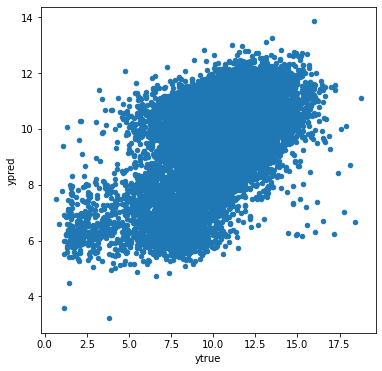

In [40]:
print(r2_score(df_eval2['ytrue'], df_eval2['ypred']))
df_eval2.plot.scatter('ytrue', 'ypred', figsize=(6, 6));

In [41]:
df_eval2.to_csv('../output/oof_kronecker_dominant.csv', index=False)

In [42]:
!ls -lh ../output/oof_kronecker*

-rw-r--r-- 1 igorf samuelbf 839K Jan 31 19:25 ../output/oof_kronecker_additive.csv
-rw-r--r-- 1 igorf samuelbf 838K Jan 31 22:25 ../output/oof_kronecker_dominant.csv
